# Road Ban Restrictions Analysis

## Objective

The objective of this script is to extract the road ban data from the available pdfs on the Alberta Open Data website and attempt to build analytics regarding the historical start dates for road bans. The analytics can help people gain a better statistical understanding of when road bans will be in effect and the degree in which it is the case.

The analytics will examine the frequency of effective dates for axles weights at 75%, 90%, 100%. The data will be normalized to the calendar year to provide insight as to how when road ban restrictions come into effect on the calendar year. The assumption is that these bans are based on weather and temperatures which is correlated with the time of the year in which they get placed.

Further analysis can be done to examine trends over time to see if there are any longitudinal trends regarding the road ban timing over time.

## Why is this important?
Transportation of goods and services are a critical part of supply chain within the oil and gas, forestry, and agricultural industries. Project logistics and costs heavily are impacted by capabilities of being able to transport necessary equipment to project sites. Understanding restrictions and the timing of information can lead to a better understanding of project risks and aid project planners and managers with tangible data to make better decisions.

Properly understanding project risks can have a significant impact on proper capital management. Being handcuffed by road ban restrictions can lead to project delays and increased costs to either increase truck traffic to reduce loads and/or upgrade and repair roads that get damaged by heavy traffic in poor conditions.

# Data Preparation

## Setup 

In [3]:
import PyPDF2
import re
import pandas as pd
import numpy as np
import datetime as dt
import os
from tabula.io import read_pdf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

## Data Files

Data is currently saved in pdf reports scraped from the Alberta Open Data website. 

In [30]:
# List of individual road ban reports from 2004 to 2013
rb_reports = os.listdir('./road ban reports/')
rb_reports

['trans-2004-road-bans-15.pdf',
 'trans-2004-road-bans-17.pdf',
 'trans-2004-road-bans-18.pdf',
 'trans-2004-road-bans-19.pdf',
 'trans-2004-road-bans-20.pdf',
 'trans-2004-road-bans-21.pdf',
 'trans-2004-road-bans-22.pdf',
 'trans-2004-road-bans-23.pdf',
 'trans-2004-road-bans-24.pdf',
 'trans-2004-road-bans-25.pdf',
 'trans-2004-road-bans-26.pdf',
 'trans-2004-road-bans-27.pdf',
 'trans-2004-road-bans-28.pdf',
 'trans-2004-road-bans-29.pdf',
 'trans-2004-road-bans-30.pdf',
 'trans-2004-road-bans-31.pdf',
 'trans-2004-road-bans-32.pdf',
 'trans-2004-road-bans-33.pdf',
 'trans-2004-road-bans-34.pdf',
 'trans-2004-road-bans-35.pdf',
 'trans-2004-road-bans-37.pdf',
 'trans-2004-road-bans-38.pdf',
 'trans-2004-road-bans-39.pdf',
 'trans-2004-road-bans-40.pdf',
 'trans-2005-road-bans-1.pdf',
 'trans-2005-road-bans-10.pdf',
 'trans-2005-road-bans-11.pdf',
 'trans-2005-road-bans-12.pdf',
 'trans-2005-road-bans-13.pdf',
 'trans-2005-road-bans-14.pdf',
 'trans-2005-road-bans-15.pdf',
 'trans-2

In [31]:
# Transportation Road Ban Summary List Reports
rb_summary_lists = os.listdir('./road ban summary lists')
rb_summary_lists

['trans-2014-road-ban-summary-list.pdf',
 'trans-2015-road-ban-summary-list.pdf',
 'trans-2016-road-ban-summary-list.pdf',
 'trans-2017-road-ban-summary-list.pdf',
 'trans-2018-road-ban-summary-list.pdf',
 'trans-2019-road-ban-summary-list.pdf',
 'trans-2020-road-ban-summary-list.pdf']

## Data Parsing

### Attempting to parse the pdf with PyPDF2
Attempting to parse the information using PyPDF2 library; however, due to the structure of the parsed results, it is very difficult to be able to do the data cleaning into a form that will be easily manipulatable.

In [3]:
pdfFileObj = open('./road ban summary lists/trans-2020-road-ban-summary-list.pdf','rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
text = []
for page in range(pdfReader.numPages):
    page = pdfReader.getPage(page).extractText()
    page = re.split(f'Page [0-9]+ of {pdfReader.numPages}',page)
    text.append(page[1])
text

['RoadDescriptionDistanceEffective DatePercentageJamieson Road1A1A10X10X222540404040Jct. 1A - 2.3 km North (Stoney Indian Reserve #144 North Boundary)0.6 km East of Jct 1X - Jamieson Road (8.0 km West of Jct. 40)Jamieson Road (8.0 km West of Jct. 40) - Ghost Lake Provincial Recreation Areakm 0.05 (Bridge #9 at Wayne) - km 4.05 (Bridge #2)km 4.05 (Bridge #2) - km 5.61 (Jct. 10)Mayerthorpe - Jct. 18Jct. 521 - Jct. 526Cadomin Jct. (47.9 km S. of Jct. 16) - Teck Coal Cardinal Ops Access Rd(39.9 km S. of Jct. 16)Cadomin Junction (47.9 km South of Jct. 16) - 1.4 km South of Jct. 47Jct. 1A - MD8 Boundary (7.8 km North of Jct. 1A)Jct. 734 (1.3 km S of Lovett River) - 19.5 km S of Jct. 47 (100 m South of Lovett Riv Prov Rec Area)March 26, 2020June 4, 2020May 27, 2019March 26, 2020June 4, 2020March 26, 2020June 4, 2020May 30, 2019March 26, 2020June 8, 2020March 26, 2020June 8, 2020March 30, 2020June 11, 2020April 8, 2008March 30, 2020June 8, 2020March 30, 2020June 8, 2020May 27, 2019March 26, 20

In [5]:
pdfReader.getDocumentInfo()

{'/Author': 'Government of Alberta – Ministry of Transportation',
 '/CreationDate': 'D:20210219091436Z',
 '/Creator': 'Oracle11gR1 AS Reports Services',
 '/Keywords': 'Security Classification: PUBLIC',
 '/ModDate': "D:20210317161912-06'00'",
 '/Producer': 'Oracle PDF driver',
 '/Subject': '2020 road bans, 2020 provincial road bans, 2020 road ban summary',
 '/Title': '2020 Road Ban Summary'}

### Using Tabula to parse tables from pdfs
The tabula library was more successful in parsing the information into a state that is much easier to manipulate using pandas and regular expressions. As can be seen below, the parser has already separated the information roughly into the desired column format that will make it easier to manipulate.

In [17]:
# Reading the pdf using the Tabula library yields the following format
filename = 'trans-2013-road-bans-35.pdf'
tables = read_pdf(f'./road ban reports/{filename}',pages='all')
print(tables)

[   HIGHWAY Unnamed: 0                            DESCRIPTION AXLE WEIGHT  \
0       1A          -  0.6 km East of Jct. 1X - Jamieson Road (8.0 km...   
1      10X          -  km 0.05 (Bridge No. 9 at Wayne) - km 4.55 (in ...   
2       25          -                                Jct. 521 - Jct. 526   
3       40          -         Jct.1A - MD8 Boundary (7.8 km North of 1A)   
4       40          -  7.8 km  North of Jct. 1A (MD 8 Boundary) - 24....   
5      NaN        NaN                                    (Richards Road)   
6       40          -  24.2 km (Richards Road) - 27.1 km (Forest Rese...   
7      500          -  Range Road 153A (km 0.4) - Range Road 135 (km ...   
8      501          -                     4.4 km East of Jct. 5 - Jct. 2   
9      501          -                                Jct. 500 - Jct. 879   
10     505          -                               Belly River - Jct. 2   
11     506          -                    Range Road 200 - Range Road 193   
12     506 

## Data Cleaning / Pre-Processing

Upon parsing the data from the various files, there are noticeably a few different formats over the years from the Alberta road ban data distribution. We will need to address them individually in order to normalize and structure the data to be usable for further analysis.

Of the reports scraped, they are noticibly organized into 3 distinct formats:
* Format 1: 2004 - 2013
* Format 2: 2014 - 2016
* Format 3: 2017 - Present

### Format 1: 2004 - 2013
Individual reports that are issued non-regularly stating the status of roads for that given report period. Multiple reports for each year are available.

In [12]:
# Extracting the effective date from the parsed pdf report 
filename = 'trans-2013-road-bans-3.pdf'
pdfFileObj = open(f'./road ban reports/{filename}','rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
text = pdfReader.getPage(0).extractText()
eff_date = dt.datetime.strptime(', '.join([x for x in text.split('\n') if 'EFFECTIVE' in x][0].split('A.M. ')[-1].split(', ')[1:]),'%B %d, %Y')
print(eff_date)

2013-03-08 00:00:00


In [14]:
# Reading the pdf yields the following format
filename = 'trans-2013-road-bans-35.pdf'
tables = read_pdf(f'./road ban reports/{filename}',pages='all')
print(tables)

[   HIGHWAY Unnamed: 0                            DESCRIPTION AXLE WEIGHT  \
0       1A          -  0.6 km East of Jct. 1X - Jamieson Road (8.0 km...   
1      10X          -  km 0.05 (Bridge No. 9 at Wayne) - km 4.55 (in ...   
2       25          -                                Jct. 521 - Jct. 526   
3       40          -         Jct.1A - MD8 Boundary (7.8 km North of 1A)   
4       40          -  7.8 km  North of Jct. 1A (MD 8 Boundary) - 24....   
5      NaN        NaN                                    (Richards Road)   
6       40          -  24.2 km (Richards Road) - 27.1 km (Forest Rese...   
7      500          -  Range Road 153A (km 0.4) - Range Road 135 (km ...   
8      501          -                     4.4 km East of Jct. 5 - Jct. 2   
9      501          -                                Jct. 500 - Jct. 879   
10     505          -                               Belly River - Jct. 2   
11     506          -                    Range Road 200 - Range Road 193   
12     506 

The data largely looks to be good; however upon closer inspection, there are certain rows with wrapped text which is incorrectly splitting up the road description creating "ghost" roads that don't exist. Additional massaging is needed to eliminate this problem. 

Example: See rows 174 & 175 in the dataframe below. The description is long and belong together in the same description row.

In [21]:
# First dataframe based on the pdf data extraction
df1 = pd.DataFrame()
for i in range(len(tables)):
    df1 = pd.concat([df1,tables[i].T.reset_index().T])
df1 = df1.iloc[1:].drop_duplicates()
df1.columns = ['Road','-','Description','Percentage']
df1.drop('-',axis=1,inplace=True)
display(df1.reset_index(drop=True))
# This version has a simple flaw that wrapped text ended up having extra rows that are split up the description

,Road,Description,Percentage
0,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,90
1,10X,km 0.05 (Bridge No. 9 at Wayne) - km 4.55 (in ...,90
2,25,Jct. 521 - Jct. 526,75
3,40,Jct.1A - MD8 Boundary (7.8 km North of 1A),90
4,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 24....,90
...,...,...,...
172,NaN,Reserve #123,NaN
173,Local:,Oiled Roads as posted in the Calling Lake Indi...,75
174,Local:,The Frog Lake Massacre Monument - 8.5 km East ...,75
175,NaN,Unipauheos Indian Reserve #121,NaN


In [372]:
# Script to clean up the raw parsed data from the initial file
data = []

# Iterates through the pages of the pdf
for i in range(len(tables)):
    
    df_temp = tables[i]
    df_temp.columns = ['Road','-','Description','Percentage']
    
    # Iterating through each rows
    for index, row in df_temp.iterrows():
        
        # Checks if the index goes out of scope because we want to look ahead a row for wrapped text
        if index < len(df_temp)-1:
            if pd.notnull(row['Road']):
                # If the following row does not have an actual entry, then it is wrapped text and adds the description to the current row
                if pd.isnull(df_temp.iloc[index+1]['Road']):
                    data.append([row['Road'],row['Description']+df_temp.iloc[index+1]['Description'],row['Percentage']])
                else:
                    # Eliminates the row with column headers
                    if row['Percentage'] == 'AXLE WEIGHT':
                        continue
                    data.append([row['Road'],row['Description'],row['Percentage']])
                    
        # Skips the row if the row is wrapped text
        if pd.isnull(row['Road']):
            continue
            
df1 = pd.DataFrame(data,columns=['Road','Description','Percentage'])
display(df1)

,Road,Description,Percentage
0,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,90
1,10X,km 0.05 (Bridge No. 9 at Wayne) - km 4.55 (in ...,90
2,25,Jct. 521 - Jct. 526,75
3,40,Jct.1A - MD8 Boundary (7.8 km North of 1A),90
4,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 24....,90
...,...,...,...
73,Local:,127 St. From the Ellerslie Road to Anthony Hen...,75
74,Local:,The English Bay Road through the Cold Lake Ind...,75
75,Local:,The Gurneyville Road from SH 657 North in the ...,75
76,Local:,Oiled Roads as posted in the Calling Lake Indi...,75


### Format 2: 2014 to 2017
Tabular format with effective dates of the various restrictions in independent columns.

In [22]:
# Reading the pdf yields the following format
filename = 'trans-2016-road-ban-summary-list.pdf'
tables = read_pdf(f'./road ban summary lists/{filename}',pages='all')
tables

[   2016 Alberta Transportation Road Bans  \
 0                                Highway   
 1                             127 Street   
 2                            Jamieson Rd   
 3                                     1A   
 4                                     1A   
 5                                     2A   
 6                                    10X   
 7                                    10X   
 8                                     22   
 9                                     25   
 10                                    40   
 11                                    40   
 12                                    40   
 13                                    40   
 14                                    40   
 15                                    40   
 16                                    40   
 17                                    40   
 18                                    41   
 19                                    56   
 20                                    66   
 21       

Looking through the dataframe below, we can quickly see how the data is organized. Instead of the specific reports indicating when restrictions are in effect, the report here summarizes when the various roads were at varying levels of restriction. The levels (i.e. 75%, 90%, Ban Off) are separated in columns.

Column headings appear to be in the first row of the dataframe.

Date formats follow a consistent format with three letters representing the month. A period follows if the length of the month is longer than 3 letters and all year denotes the road's state the entire year. The year is not specified in the date and is inferred from the year of the report.

In [23]:
# Unformatted, the extracted table has the following form
df2 = pd.DataFrame(tables[0])
display(df2)

,2016 Alberta Transportation Road Bans,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Highway,Section,Dist. (km),75%,90%,Ban Off
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,all year,NaN,NaN
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,Apr. 24,NaN,May. 16
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,Feb. 11,May 16,NaN
4,1A,Jamieson Road (Range Road 64A - 8.14 km West o...,3.7,Apr. 24,NaN,May. 16
5,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaN,Mar. 14,NaN
6,10X,km 0.05 (bridge #9 at Wayne) - km 4.05 (Bridge...,4.5,Mar. 7,May 16,NaN
7,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1,Mar. 7,NaN,May. 16
8,22,Mayerthorpe - Jct. 18,6.9,Mar. 7,NaN,Jun. 6
9,25,Jct. 521 - Jct. 526,19.4,all year,NaN,NaN


Cleaning up the data we have the following changes:
* Column names are now where they should be
* Dates have been converted to datetime objects complete with year
* Data still remains in the structure initially parsed

In [24]:
year = int(filename.split('-')[1])

# Resets the column names to the first row
df = tables[0].T.reset_index(drop=True).set_index(0).T

# Setting the effective date to the first day of the year for all year restriction designations
df['75%'] = df['75%'].apply(lambda x: dt.datetime(year,1,1) if x == 'all year' else x)
df['90%'] = df['90%'].apply(lambda x: dt.datetime(year,1,1) if x == 'all year' else x)
df['Ban Off'] = df['Ban Off'].apply(lambda x: dt.datetime(year,1,1) if x == 'all year' else x)

# Reformatting effective date data type from string to datetime
df['75%'] = df['75%'].apply(lambda x: dt.datetime.strptime(re.sub('\.','',x)+f' {year}','%b %d %Y') if type(x)==str else x)
df['90%'] = df['90%'].apply(lambda x: dt.datetime.strptime(re.sub('\.','',x)+f' {year}','%b %d %Y') if type(x)==str else x)
df['Ban Off'] = df['Ban Off'].apply(lambda x: dt.datetime.strptime(re.sub('\.','',x)+f' {year}','%b %d %Y') if type(x)==str else x)
df

,Highway,Section,Dist. (km),75%,90%,Ban Off
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2016-01-01,NaT,NaT
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,2016-04-24,NaT,2016-05-16
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2016-02-11,2016-05-16,NaT
4,1A,Jamieson Road (Range Road 64A - 8.14 km West o...,3.7,2016-04-24,NaT,2016-05-16
5,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaT,2016-03-14,NaT
6,10X,km 0.05 (bridge #9 at Wayne) - km 4.05 (Bridge...,4.5,2016-03-07,2016-05-16,NaT
7,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1,2016-03-07,NaT,2016-05-16
8,22,Mayerthorpe - Jct. 18,6.9,2016-03-07,NaT,2016-06-06
9,25,Jct. 521 - Jct. 526,19.4,2016-01-01,NaT,NaT
10,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,2016-02-11,2016-05-16,NaT


Standardization between the 3 different formats of the road ban reports is needed to consolidate the data for further analytical use. The state in which the ban status for each road are split into 3 columns are not compatible with the other two formats. We'll need to unstack the data to have the data structured similarly. The following cell will accompmlish this.

In [25]:
# Unstacking the dataframe to the form in the most recent road ban summary report (Format 3)
data = []
for index, row in df.iterrows():
    if pd.notnull(row['75%']):
        data.append([row['Highway'],row['Section'],row['Dist. (km)'],row['75%'],75])
    if pd.notnull(row['90%']):
        data.append([row['Highway'],row['Section'],row['Dist. (km)'],row['90%'],90])
    if pd.notnull(row['Ban Off']):
        data.append([row['Highway'],row['Section'],row['Dist. (km)'],row['Ban Off'],100])
df2 = pd.DataFrame(data, columns=['Road','Description','Distance','Effective Date','Percentage'])
display(df2)

,Road,Description,Distance,Effective Date,Percentage
0,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2016-01-01,75
1,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,2016-04-24,75
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,2016-05-16,100
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2016-02-11,75
4,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2016-05-16,90
...,...,...,...,...,...
63,512,Lethbridge - Jct. 845,11.3,2016-05-16,100
64,519,Nobleford - Jct. 25,17.7,2016-02-11,90
65,519,Nobleford - Jct. 25,17.7,2016-05-16,100
66,519,Picture Butte - Jct. 845,12.2,2016-02-11,90


### Format 3: 2017 to Present
Is created as a tabular format that stats the effective times of the various restrictions.

In [26]:
# Reading the pdf yields the following format
filename = 'trans-2020-road-ban-summary-list.pdf'
tables = read_pdf(f'./road ban summary lists/{filename}',pages='all')
tables

[   Jamieson Road  \
 0            NaN   
 1             1A   
 2            NaN   
 3            NaN   
 4             1A   
 5            NaN   
 6            NaN   
 7            10X   
 8            NaN   
 9            NaN   
 10           10X   
 11           NaN   
 12            22   
 13           NaN   
 14            25   
 15            40   
 16           NaN   
 17           NaN   
 18            40   
 19           NaN   
 20            40   
 21           NaN   
 22           NaN   
 23            40   
 
    Jct. 1A - 2.3 km North (Stoney Indian Reserve #144 North Boundary)  \
 0                                                 NaN                   
 1   0.6 km East of Jct 1X - Jamieson Road (8.0 km ...                   
 2                                                 NaN                   
 3                                                 NaN                   
 4   Jamieson Road (8.0 km West of Jct. 40) - Ghost...                   
 5                           

Looking through the dataframe below, we can see how the data is organized. These reports indicating when restrictions are in effect, by means of a transactional entries. When the status of each road changes, there is a date and a new Percentage Axle Weight entry.

Column headings appear to be fine.
Date formats follow a consistent format with "month day, year".
Percentage axle weight data appears to be in a string form with "Lifted" representing 100%
Many road entries and descriptions are null values due to the "merged cell" or "wrapped text" formatting used in the pdf report

In [29]:
# Dataframe from the data table extraction
df3 = tables[0].T.reset_index().T.reset_index(drop=True)
df3.columns = ['Road','Description','Distance','Effective Date','Percentage']
display(df3)

,Road,Description,Distance,Effective Date,Percentage
0,Jamieson Road,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3 km,"March 26, 2020",75%
1,NaN,NaN,NaN,"June 4, 2020",Lifted
2,1A,0.6 km East of Jct 1X - Jamieson Road (8.0 km ...,27.9 km,"May 27, 2019",90%
3,NaN,NaN,NaN,"March 26, 2020",75%
4,NaN,NaN,NaN,"June 4, 2020",90%
5,1A,Jamieson Road (8.0 km West of Jct. 40) - Ghost...,3.7 km,"March 26, 2020",75%
6,NaN,Recreation Area,NaN,NaN,NaN
7,NaN,NaN,NaN,"June 4, 2020",Lifted
8,10X,km 0.05 (Bridge #9 at Wayne) - km 4.05 (Bridge...,4.5 km,"May 30, 2019",90%
9,NaN,NaN,NaN,"March 26, 2020",75%


In [32]:
df3 = tables[0].T.reset_index().T.reset_index(drop=True)
df3.columns = ['Road','Description','Distance','Effective Date','Percentage']
# Backfill the empty rows that are from the wrapped text
df3.fillna(method='bfill', inplace=True)
df3.sort_values(by=['Road','Effective Date'], ascending=True)

,Road,Description,Distance,Effective Date,Percentage
6,10X,Recreation Area,4.5 km,"June 4, 2020",Lifted
7,10X,km 0.05 (Bridge #9 at Wayne) - km 4.05 (Bridge...,4.5 km,"June 4, 2020",Lifted
10,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1 km,"June 8, 2020",90%
9,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1 km,"March 26, 2020",75%
11,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1 km,"March 26, 2020",75%
8,10X,km 0.05 (Bridge #9 at Wayne) - km 4.05 (Bridge...,4.5 km,"May 30, 2019",90%
1,1A,0.6 km East of Jct 1X - Jamieson Road (8.0 km ...,27.9 km,"June 4, 2020",Lifted
4,1A,Jamieson Road (8.0 km West of Jct. 40) - Ghost...,3.7 km,"June 4, 2020",90%
3,1A,Jamieson Road (8.0 km West of Jct. 40) - Ghost...,3.7 km,"March 26, 2020",75%
5,1A,Jamieson Road (8.0 km West of Jct. 40) - Ghost...,3.7 km,"March 26, 2020",75%


## Consolidating all available tables in directory

In [32]:
rb_reports

['trans-2004-road-bans-15.pdf',
 'trans-2004-road-bans-17.pdf',
 'trans-2004-road-bans-18.pdf',
 'trans-2004-road-bans-19.pdf',
 'trans-2004-road-bans-20.pdf',
 'trans-2004-road-bans-21.pdf',
 'trans-2004-road-bans-22.pdf',
 'trans-2004-road-bans-23.pdf',
 'trans-2004-road-bans-24.pdf',
 'trans-2004-road-bans-25.pdf',
 'trans-2004-road-bans-26.pdf',
 'trans-2004-road-bans-27.pdf',
 'trans-2004-road-bans-28.pdf',
 'trans-2004-road-bans-29.pdf',
 'trans-2004-road-bans-30.pdf',
 'trans-2004-road-bans-31.pdf',
 'trans-2004-road-bans-32.pdf',
 'trans-2004-road-bans-33.pdf',
 'trans-2004-road-bans-34.pdf',
 'trans-2004-road-bans-35.pdf',
 'trans-2004-road-bans-37.pdf',
 'trans-2004-road-bans-38.pdf',
 'trans-2004-road-bans-39.pdf',
 'trans-2004-road-bans-40.pdf',
 'trans-2005-road-bans-1.pdf',
 'trans-2005-road-bans-10.pdf',
 'trans-2005-road-bans-11.pdf',
 'trans-2005-road-bans-12.pdf',
 'trans-2005-road-bans-13.pdf',
 'trans-2005-road-bans-14.pdf',
 'trans-2005-road-bans-15.pdf',
 'trans-2

In [33]:
rb_summary_lists

['trans-2014-road-ban-summary-list.pdf',
 'trans-2015-road-ban-summary-list.pdf',
 'trans-2016-road-ban-summary-list.pdf',
 'trans-2017-road-ban-summary-list.pdf',
 'trans-2018-road-ban-summary-list.pdf',
 'trans-2019-road-ban-summary-list.pdf',
 'trans-2020-road-ban-summary-list.pdf']

In [13]:
format2 = []
format3 = []
for f in rb_summary_lists:
    if f.split('-')[1] in {'2014','2015','2016'}:
        format2.append(f)
    else:
        format3.append(f)
print(format2)
print(format3)

['trans-2014-road-ban-summary-list.pdf', 'trans-2015-road-ban-summary-list.pdf', 'trans-2016-road-ban-summary-list.pdf']
['trans-2017-road-ban-summary-list.pdf', 'trans-2018-road-ban-summary-list.pdf', 'trans-2019-road-ban-summary-list.pdf', 'trans-2020-road-ban-summary-list.pdf']


### Format 1: 2004 - 2013

In [42]:
# Using the pre-processing on the pdf report to format data into most recent format of road ban data
data = []
for f in rb_reports[:10]:
    pdf_tables = read_pdf(f'./road ban reports/{f}',pages='all')
    
    # Parsing pdf file for the effective date of the report
    pdfFileObj = open(f'./road ban reports/{f}','rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    text = pdfReader.getPage(0).extractText()
    eff_date = re.findall('[A-Z][a-z]+ [0-9]+\s*, [0-9]{4}',text)[0]
    eff_date = re.sub(' ,',',',eff_date)
    eff_date = dt.datetime.strptime(eff_date,'%B %d, %Y')
    
    # Iterating through the pdf pages
    for i in range(len(pdf_tables)):
        df_temp = pdf_tables[i]
#         display(df_temp)
        df_temp.columns = ['Road','-','Description','Percentage']
        for index, row in df_temp.iterrows():
#             display(row)
            if index < len(df_temp)-1:
                if pd.notnull(row['Road']):
                    if pd.isnull(df_temp.iloc[index+1]['Road']):
                        data.append([row['Road'],row['Description']+df_temp.iloc[index+1]['Description'],eff_date,row['Percentage']])
                    else:
                        if row['Percentage'] == 'AXLE WEIGHT':
                            continue
                        data.append([row['Road'],row['Description'],eff_date,row['Percentage']])
            if pd.isnull(row['Road']):
                continue
    print(f"Finished {f}")
df1 = pd.DataFrame(data,columns=['Road','Description','Effective Date','Percentage'])
display(df1)

Finished trans-2004-road-bans-15.pdf


Finished trans-2004-road-bans-17.pdf
Finished trans-2004-road-bans-18.pdf
Finished trans-2004-road-bans-19.pdf
Finished trans-2004-road-bans-20.pdf
Finished trans-2004-road-bans-21.pdf
Finished trans-2004-road-bans-22.pdf
Finished trans-2004-road-bans-23.pdf
Finished trans-2004-road-bans-24.pdf
Finished trans-2004-road-bans-25.pdf


,Road,Description,Effective Date,Percentage
0,1A,Jct. 1X - Jamieson Road (8.0 km West of Jct. 40),2004-04-19,75
1,2A,0.8 km N. of Jct. 54 - 4.0 km North of Jct. 54,2004-04-19,90
2,2A,Jct. 42 - Red Deer (Bettenson pit access),2004-04-19,75
3,2A,Grimshaw - 2 km South of Jct. 2 (Roma),2004-04-19,90
4,2A,4.0 km North of Jct. 54 - Penhold,2004-04-19,75
...,...,...,...,...
1677,63,BoyleNewbrook (SH 661),2004-06-03,100
1678,69,Fort McMurray Airport,2004-06-03,100
1679,Local:,The English Bay Road through the Cold Lake Ind...,2004-06-03,75
1680,Local:,The Gurneyville Road from SH 657 North in the ...,2004-06-03,75


In [27]:
# Extracting the effective date from the parsed pdf report 
filename = 'trans-2006-road-bans-14.pdf'
pdfFileObj = open(f'./road ban reports/{filename}','rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
text = pdfReader.getPage(0).extractText()
# eff_date = dt.datetime.strptime(', '.join([x for x in text.split('\n') if 'EFFECTIVE' in x][0].split('A.M. ')[-1].split(', ')[1:]),'%B %d, %Y')
eff_date = re.findall('[A-Z][a-z]+ [0-9]+\s*, [0-9]{4}',text)[0]
eff_date = re.sub(' ,',',',eff_date)
print(eff_date)


May 2, 2006


In [447]:
test_str = 'Alberta TransportationEFFECTIVE 2:00 P.M. Monday, April 19, 2004ORDER NO. 04 - ROAD - 15This Order rescinds Order No. 04 - ROAD - 14ALBERTA TRANSPORTATION'
re.findall('[0-9]+:[0-9]+ [A-Z].[A-Z]. [A-Z][a-z]+, [A-Z][a-z]+ [0-9]+, [0-9]{4}',test_str)
re.findall('[A-Z][a-z]+ [0-9]+, [0-9]{4}',test_str)

['April 19, 2004']

In [ ]:
data = []
for i in range(len(tables)):
    df_temp = tables[i]
    df_temp.columns = ['Road','-','Description','Percentage']
    for index, row in df_temp.iterrows():
        if index < len(df_temp)-1:
            if pd.notnull(row['Road']):
                if pd.isnull(df_temp.iloc[index+1]['Road']):
                    data.append([row['Road'],row['Description']+df_temp.iloc[index+1]['Description'],row['Percentage']])
                else:
                    if row['Percentage'] == 'AXLE WEIGHT':
                        continue
                    data.append([row['Road'],row['Description'],row['Percentage']])
        if pd.isnull(row['Road']):
            continue
df1 = pd.DataFrame(data,columns=['Road','Description','Percentage'])

### Format 2: 2014 - 2017

In [121]:
data = []

for f in format2:
    print(f)
    pdf_tables = read_pdf(f'./road ban summary lists/{f}',pages='all')
    year = int(f.split('-')[1])
    for i in range(len(pdf_tables)):
        print(f"i:{i}")
        if i == 0:
            df_temp = pdf_tables[i].T.reset_index(drop=True).set_index(0).T            
        else:
            df_temp = pdf_tables[i]
        display(df_temp)
        for col in ['75%','90%','Ban Off']:
            df_temp[col] = df_temp[col].apply(lambda x: np.nan if x == 'N/A' else x) # Replaces N/A with a null value
            df_temp[col] = df_temp[col].apply(lambda x: dt.datetime(1900,1,1)+dt.timedelta(days=int(x)) if str(x).isnumeric() else x) # Meant for accidental excel formatting of date into a numerical value
            df_temp[col] = df_temp[col].apply(lambda x: re.sub('\.','. ',x) if type(x)==str else x) # Eliminating typo error missing a space to divide
            df_temp[col] = df_temp[col].apply(lambda x: re.sub('\s+',' ',x) if type(x)==str else x) # Eliminating stray multiple consecutive spaces
            df_temp[col] = df_temp[col].apply(lambda x: re.sub('(\d+)%','',x) if type(x)==str else x) # Eliminating axle weight percentages
            df_temp[col] = df_temp[col].apply(lambda x: re.sub('[\(\)]','',x) if type(x)==str else x) # Eliminating brackets
            df_temp[col] = df_temp[col].apply(lambda x: x.rstrip() if type(x)==str else x) # Eliminating trailing spaces
            df_temp[col] = df_temp[col].apply(lambda x: dt.datetime(year,1,1) if ('all year' in str(x)) & (type(x)==str) else x) # Uses the start of the year (Jan 1) for entries containing all year
            df_temp[col] = df_temp[col].apply(lambda x: x.split('/')[0] if type(x)==str else x) # Uses the first date in a dual date entry separated with a /
            df_temp[col] = df_temp[col].apply(lambda x: re.sub('[\.\(\),]','',x)+f' {year}' if (type(x)==str) & (len(str(x).split(' '))<3) else x) # For entries that include the year in the entry this ensures the year in the entry is used
            df_temp[col] = df_temp[col].apply(lambda x: ' '.join([y[:3] if i == 0 else y for i,y in enumerate(x.split(' '))]) if (type(x)==str) & (len(str(x).split(' ')[0])>3) else x)
            df_temp[col] = df_temp[col].apply(lambda x: dt.datetime.strptime(re.sub('[\.\(\),]','',x),'%b %d %Y') if type(x)==str else x) # Removes the abbreviation "." and the brackets
#         df_temp['90%'] = df_temp['90%'].apply(lambda x: dt.datetime(year,1,1) if x == 'all year' else x)
#         df_temp['90%'] = df_temp['90%'].apply(lambda x: dt.datetime.strptime(re.sub('[\.\(\.\)]','',x)+f' {year}','%b %d %Y') if type(x)==str else x)
#         df_temp['Ban Off'] = df_temp['Ban Off'].apply(lambda x: dt.datetime(year,1,1) if x == 'all year' else x)
#         df_temp['Ban Off'] = df_temp['Ban Off'].apply(lambda x: dt.datetime.strptime(re.sub('[\.\(\.\)]','',x)+f' {year}','%b %d %Y') if type(x)==str else x)
        for index, row in df_temp.iterrows():
            if pd.notnull(row['75%']):
                data.append([row['Highway'],row['Section'],row['Dist. (km)'],row['75%'],75])
            if pd.notnull(row['90%']):
                data.append([row['Highway'],row['Section'],row['Dist. (km)'],row['90%'],90])
            if pd.notnull(row['Ban Off']):
                data.append([row['Highway'],row['Section'],row['Dist. (km)'],row['Ban Off'],100])
df2 = pd.DataFrame(data, columns=['Road','Description','Distance','Effective Date','Percentage'])
df2

trans-2014-road-ban-summary-list.pdf
i:0


,Highway,Section,Dist. (km),90%,75%,Ban Off
1,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,27.9,Oct. 2,Mar. 10,NaN
2,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,all year,Mar. 10,NaN
3,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,NaN,all year (Mar. 10),NaN
4,22,Mayerthorpe - Jct. 18,6.9,NaN,Mar. 31,Jun. 23
5,25,Jct. 521 - Jct. 526,19.4,NaN,all year,NaN
6,29,Jct. 831 - Jct. 855,29.4,NaN,Mar. 17,Aug. 28
7,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,NaN,Apr. 1 (2013),NaN
8,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,NaN,Apr. 1 (2013),NaN
9,40,23.9 km N. of Jct. 1A (Richards Rd.) - 27.1 km...,3.2,NaN,Apr. 1 (2013),NaN
10,40,36.1 km South of Jct. 47 - Jct. 47,35.7,NaN,Apr. 7,Jun. 9


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
1,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,27.9,Oct. 2,Mar. 10,NaN,<class 'str'>
2,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,all year,Mar. 10,NaN,<class 'str'>
3,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
4,22,Mayerthorpe - Jct. 18,6.9,NaN,Mar. 31,Jun. 23,<class 'str'>
5,25,Jct. 521 - Jct. 526,19.4,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
6,29,Jct. 831 - Jct. 855,29.4,NaN,Mar. 17,Aug. 28,<class 'str'>
7,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,NaN,Apr. 1 2013,NaN,<class 'str'>
8,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,NaN,Apr. 1 2013,NaN,<class 'str'>
9,40,23.9 km N. of Jct. 1A (Richards Rd.) - 27.1 km...,3.2,NaN,Apr. 1 2013,NaN,<class 'str'>
10,40,36.1 km South of Jct. 47 - Jct. 47,35.7,NaN,Apr. 7,Jun. 9,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
1,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,27.9,Oct. 2,Mar 10 2014,NaN,<class 'str'>
2,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,all year,Mar 10 2014,NaN,<class 'str'>
3,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
4,22,Mayerthorpe - Jct. 18,6.9,NaN,Mar 31 2014,Jun. 23,<class 'str'>
5,25,Jct. 521 - Jct. 526,19.4,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
6,29,Jct. 831 - Jct. 855,29.4,NaN,Mar 17 2014,Aug. 28,<class 'str'>
7,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,NaN,Apr 1 2013,NaN,<class 'str'>
8,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,NaN,Apr 1 2013,NaN,<class 'str'>
9,40,23.9 km N. of Jct. 1A (Richards Rd.) - 27.1 km...,3.2,NaN,Apr 1 2013,NaN,<class 'str'>
10,40,36.1 km South of Jct. 47 - Jct. 47,35.7,NaN,Apr 7 2014,Jun. 9,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
1,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,27.9,Oct. 2,2014-03-10,NaN,<class 'str'>,<class 'str'>
2,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-01-01 00:00:00,2014-03-10,NaN,<class 'str'>,<class 'datetime.datetime'>
3,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
4,22,Mayerthorpe - Jct. 18,6.9,NaN,2014-03-31,Jun. 23,<class 'str'>,<class 'float'>
5,25,Jct. 521 - Jct. 526,19.4,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
6,29,Jct. 831 - Jct. 855,29.4,NaN,2014-03-17,Aug. 28,<class 'str'>,<class 'float'>
7,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,NaN,2013-04-01,NaN,<class 'str'>,<class 'float'>
8,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,NaN,2013-04-01,NaN,<class 'str'>,<class 'float'>
9,40,23.9 km N. of Jct. 1A (Richards Rd.) - 27.1 km...,3.2,NaN,2013-04-01,NaN,<class 'str'>,<class 'float'>
10,40,36.1 km South of Jct. 47 - Jct. 47,35.7,NaN,2014-04-07,Jun. 9,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
1,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,27.9,Oct 2 2014,2014-03-10,NaN,<class 'str'>,<class 'str'>
2,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-01-01 00:00:00,2014-03-10,NaN,<class 'str'>,<class 'datetime.datetime'>
3,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
4,22,Mayerthorpe - Jct. 18,6.9,NaN,2014-03-31,Jun. 23,<class 'str'>,<class 'float'>
5,25,Jct. 521 - Jct. 526,19.4,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
6,29,Jct. 831 - Jct. 855,29.4,NaN,2014-03-17,Aug. 28,<class 'str'>,<class 'float'>
7,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,NaN,2013-04-01,NaN,<class 'str'>,<class 'float'>
8,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,NaN,2013-04-01,NaN,<class 'str'>,<class 'float'>
9,40,23.9 km N. of Jct. 1A (Richards Rd.) - 27.1 km...,3.2,NaN,2013-04-01,NaN,<class 'str'>,<class 'float'>
10,40,36.1 km South of Jct. 47 - Jct. 47,35.7,NaN,2014-04-07,Jun. 9,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
1,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,27.9,2014-10-02,2014-03-10,NaN,<class 'str'>,<class 'str'>,<class 'float'>
2,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-01-01,2014-03-10,NaN,<class 'str'>,<class 'datetime.datetime'>,<class 'float'>
3,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
4,22,Mayerthorpe - Jct. 18,6.9,NaT,2014-03-31,Jun. 23,<class 'str'>,<class 'float'>,<class 'str'>
5,25,Jct. 521 - Jct. 526,19.4,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
6,29,Jct. 831 - Jct. 855,29.4,NaT,2014-03-17,Aug. 28,<class 'str'>,<class 'float'>,<class 'str'>
7,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,NaT,2013-04-01,NaN,<class 'str'>,<class 'float'>,<class 'float'>
8,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,NaT,2013-04-01,NaN,<class 'str'>,<class 'float'>,<class 'float'>
9,40,23.9 km N. of Jct. 1A (Richards Rd.) - 27.1 km...,3.2,NaT,2013-04-01,NaN,<class 'str'>,<class 'float'>,<class 'float'>
10,40,36.1 km South of Jct. 47 - Jct. 47,35.7,NaT,2014-04-07,Jun. 9,<class 'str'>,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
1,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,27.9,2014-10-02,2014-03-10,NaN,<class 'str'>,<class 'str'>,<class 'float'>
2,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-01-01,2014-03-10,NaN,<class 'str'>,<class 'datetime.datetime'>,<class 'float'>
3,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
4,22,Mayerthorpe - Jct. 18,6.9,NaT,2014-03-31,Jun 23 2014,<class 'str'>,<class 'float'>,<class 'str'>
5,25,Jct. 521 - Jct. 526,19.4,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
6,29,Jct. 831 - Jct. 855,29.4,NaT,2014-03-17,Aug 28 2014,<class 'str'>,<class 'float'>,<class 'str'>
7,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,NaT,2013-04-01,NaN,<class 'str'>,<class 'float'>,<class 'float'>
8,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,NaT,2013-04-01,NaN,<class 'str'>,<class 'float'>,<class 'float'>
9,40,23.9 km N. of Jct. 1A (Richards Rd.) - 27.1 km...,3.2,NaT,2013-04-01,NaN,<class 'str'>,<class 'float'>,<class 'float'>
10,40,36.1 km South of Jct. 47 - Jct. 47,35.7,NaT,2014-04-07,Jun 9 2014,<class 'str'>,<class 'float'>,<class 'str'>


i:1


,Highway,Section,Dist. (km),90%,75%,Ban Off
0,512,Lethbridge - Jct. 845,11.3,Mar. 10,NaN,Jun. 9
1,519,Nobleford - Jct. 25,17.7,Mar. 10,NaN,Jun. 9
2,519,Picture Butte - Jct. 845,12.2,Mar. 10,NaN,Dec. 22
3,520,Range Road 283 - Claresholm Industrial Airport,7.4,all year,NaN,NaN
4,521,3.2 km East of Jct. 25 - Jct. 864,19.3,NaN,all year,NaN
5,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,NaN,all year,NaN
6,524,Jct. 864 - Vauxhall,9.3,Oct. 2,all year,NaN
7,537,Jct. 41 - The Saskatchewan Border,6.5,NaN,Mar. 10,Jul. 3
8,540,64 St. West (18.9 km West of Jct. 2) - Jct. 2,18.9,NaN,Mar. 10,Mar. 17
9,540,104 St. East - 64 St. West,16.9,NaN,Mar. 17,Jun. 9


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
0,512,Lethbridge - Jct. 845,11.3,Mar. 10,NaN,Jun. 9,<class 'float'>
1,519,Nobleford - Jct. 25,17.7,Mar. 10,NaN,Jun. 9,<class 'float'>
2,519,Picture Butte - Jct. 845,12.2,Mar. 10,NaN,Dec. 22,<class 'float'>
3,520,Range Road 283 - Claresholm Industrial Airport,7.4,all year,NaN,NaN,<class 'float'>
4,521,3.2 km East of Jct. 25 - Jct. 864,19.3,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
5,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
6,524,Jct. 864 - Vauxhall,9.3,Oct. 2,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
7,537,Jct. 41 - The Saskatchewan Border,6.5,NaN,Mar. 10,Jul. 3,<class 'str'>
8,540,64 St. West (18.9 km West of Jct. 2) - Jct. 2,18.9,NaN,Mar. 10,Mar. 17,<class 'str'>
9,540,104 St. East - 64 St. West,16.9,NaN,Mar. 17,Jun. 9,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
0,512,Lethbridge - Jct. 845,11.3,Mar. 10,NaN,Jun. 9,<class 'float'>
1,519,Nobleford - Jct. 25,17.7,Mar. 10,NaN,Jun. 9,<class 'float'>
2,519,Picture Butte - Jct. 845,12.2,Mar. 10,NaN,Dec. 22,<class 'float'>
3,520,Range Road 283 - Claresholm Industrial Airport,7.4,all year,NaN,NaN,<class 'float'>
4,521,3.2 km East of Jct. 25 - Jct. 864,19.3,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
5,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
6,524,Jct. 864 - Vauxhall,9.3,Oct. 2,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
7,537,Jct. 41 - The Saskatchewan Border,6.5,NaN,Mar 10 2014,Jul. 3,<class 'str'>
8,540,64 St. West (18.9 km West of Jct. 2) - Jct. 2,18.9,NaN,Mar 10 2014,Mar. 17,<class 'str'>
9,540,104 St. East - 64 St. West,16.9,NaN,Mar 17 2014,Jun. 9,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
0,512,Lethbridge - Jct. 845,11.3,Mar. 10,NaT,Jun. 9,<class 'float'>,<class 'str'>
1,519,Nobleford - Jct. 25,17.7,Mar. 10,NaT,Jun. 9,<class 'float'>,<class 'str'>
2,519,Picture Butte - Jct. 845,12.2,Mar. 10,NaT,Dec. 22,<class 'float'>,<class 'str'>
3,520,Range Road 283 - Claresholm Industrial Airport,7.4,2014-01-01 00:00:00,NaT,NaN,<class 'float'>,<class 'datetime.datetime'>
4,521,3.2 km East of Jct. 25 - Jct. 864,19.3,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
5,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
6,524,Jct. 864 - Vauxhall,9.3,Oct. 2,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'str'>
7,537,Jct. 41 - The Saskatchewan Border,6.5,NaN,2014-03-10,Jul. 3,<class 'str'>,<class 'float'>
8,540,64 St. West (18.9 km West of Jct. 2) - Jct. 2,18.9,NaN,2014-03-10,Mar. 17,<class 'str'>,<class 'float'>
9,540,104 St. East - 64 St. West,16.9,NaN,2014-03-17,Jun. 9,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
0,512,Lethbridge - Jct. 845,11.3,Mar 10 2014,NaT,Jun. 9,<class 'float'>,<class 'str'>
1,519,Nobleford - Jct. 25,17.7,Mar 10 2014,NaT,Jun. 9,<class 'float'>,<class 'str'>
2,519,Picture Butte - Jct. 845,12.2,Mar 10 2014,NaT,Dec. 22,<class 'float'>,<class 'str'>
3,520,Range Road 283 - Claresholm Industrial Airport,7.4,2014-01-01 00:00:00,NaT,NaN,<class 'float'>,<class 'datetime.datetime'>
4,521,3.2 km East of Jct. 25 - Jct. 864,19.3,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
5,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
6,524,Jct. 864 - Vauxhall,9.3,Oct 2 2014,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'str'>
7,537,Jct. 41 - The Saskatchewan Border,6.5,NaN,2014-03-10,Jul. 3,<class 'str'>,<class 'float'>
8,540,64 St. West (18.9 km West of Jct. 2) - Jct. 2,18.9,NaN,2014-03-10,Mar. 17,<class 'str'>,<class 'float'>
9,540,104 St. East - 64 St. West,16.9,NaN,2014-03-17,Jun. 9,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
0,512,Lethbridge - Jct. 845,11.3,2014-03-10,NaT,Jun. 9,<class 'float'>,<class 'str'>,<class 'str'>
1,519,Nobleford - Jct. 25,17.7,2014-03-10,NaT,Jun. 9,<class 'float'>,<class 'str'>,<class 'str'>
2,519,Picture Butte - Jct. 845,12.2,2014-03-10,NaT,Dec. 22,<class 'float'>,<class 'str'>,<class 'str'>
3,520,Range Road 283 - Claresholm Industrial Airport,7.4,2014-01-01,NaT,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
4,521,3.2 km East of Jct. 25 - Jct. 864,19.3,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
5,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
6,524,Jct. 864 - Vauxhall,9.3,2014-10-02,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'str'>,<class 'float'>
7,537,Jct. 41 - The Saskatchewan Border,6.5,NaT,2014-03-10,Jul. 3,<class 'str'>,<class 'float'>,<class 'str'>
8,540,64 St. West (18.9 km West of Jct. 2) - Jct. 2,18.9,NaT,2014-03-10,Mar. 17,<class 'str'>,<class 'float'>,<class 'str'>
9,540,104 St. East - 64 St. West,16.9,NaT,2014-03-17,Jun. 9,<class 'str'>,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
0,512,Lethbridge - Jct. 845,11.3,2014-03-10,NaT,Jun 9 2014,<class 'float'>,<class 'str'>,<class 'str'>
1,519,Nobleford - Jct. 25,17.7,2014-03-10,NaT,Jun 9 2014,<class 'float'>,<class 'str'>,<class 'str'>
2,519,Picture Butte - Jct. 845,12.2,2014-03-10,NaT,Dec 22 2014,<class 'float'>,<class 'str'>,<class 'str'>
3,520,Range Road 283 - Claresholm Industrial Airport,7.4,2014-01-01,NaT,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
4,521,3.2 km East of Jct. 25 - Jct. 864,19.3,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
5,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
6,524,Jct. 864 - Vauxhall,9.3,2014-10-02,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'str'>,<class 'float'>
7,537,Jct. 41 - The Saskatchewan Border,6.5,NaT,2014-03-10,Jul 3 2014,<class 'str'>,<class 'float'>,<class 'str'>
8,540,64 St. West (18.9 km West of Jct. 2) - Jct. 2,18.9,NaT,2014-03-10,Mar 17 2014,<class 'str'>,<class 'float'>,<class 'str'>
9,540,104 St. East - 64 St. West,16.9,NaT,2014-03-17,Jun 9 2014,<class 'str'>,<class 'float'>,<class 'str'>


i:2


,Highway,Section,Dist. (km),90%,75%,Ban Off
0,654,Jct. 764 - Jct. 33,17.7,Mar. 31,NaN,Jun. 12
1,655,Jct. 763 - Mystery Lake,9.8,Mar. 31,NaN,Jun. 12
2,661,Ft. Assiniboine - 14.3 km north,14.3,Mar. 31,NaN,Jun. 12
3,667,Jct. 722 - Jct. 43,6.6,NaN,Mar. 31,Jun. 5
4,672,Jct. 724 - Range Road 63 (3 km west of hwy 2),19.3,NaN,Apr. 10,Jun. 26
5,677,Jct. 724 (Twp 762) - Jct. 731,12.8,NaN,Mar. 31,Jun. 26
6,677,Jct. 2 - Jct. 733,19.6,NaN,Mar. 31,Jun. 5
7,679,6.9 km East of Jct. 749 - Jct. 750,20.5,NaN,Apr. 10,May 27.
8,680,Jct. 725 - Jct. 727,14.7,NaN,Mar. 31,Jun. 5
9,681,Jct. Hwy. 719 (km 0.000) to Jct. Twp. Rd. 814 ...,23.0,NaN,Mar. 24,Dec. 4


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
0,654,Jct. 764 - Jct. 33,17.7,Mar. 31,NaN,Jun. 12,<class 'float'>
1,655,Jct. 763 - Mystery Lake,9.8,Mar. 31,NaN,Jun. 12,<class 'float'>
2,661,Ft. Assiniboine - 14.3 km north,14.3,Mar. 31,NaN,Jun. 12,<class 'float'>
3,667,Jct. 722 - Jct. 43,6.6,NaN,Mar. 31,Jun. 5,<class 'str'>
4,672,Jct. 724 - Range Road 63 (3 km west of hwy 2),19.3,NaN,Apr. 10,Jun. 26,<class 'str'>
5,677,Jct. 724 (Twp 762) - Jct. 731,12.8,NaN,Mar. 31,Jun. 26,<class 'str'>
6,677,Jct. 2 - Jct. 733,19.6,NaN,Mar. 31,Jun. 5,<class 'str'>
7,679,6.9 km East of Jct. 749 - Jct. 750,20.5,NaN,Apr. 10,May 27.,<class 'str'>
8,680,Jct. 725 - Jct. 727,14.7,NaN,Mar. 31,Jun. 5,<class 'str'>
9,681,Jct. Hwy. 719 (km 0.000) to Jct. Twp. Rd. 814 ...,23.0,NaN,Mar. 24,Dec. 4,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
0,654,Jct. 764 - Jct. 33,17.7,Mar. 31,NaN,Jun. 12,<class 'float'>
1,655,Jct. 763 - Mystery Lake,9.8,Mar. 31,NaN,Jun. 12,<class 'float'>
2,661,Ft. Assiniboine - 14.3 km north,14.3,Mar. 31,NaN,Jun. 12,<class 'float'>
3,667,Jct. 722 - Jct. 43,6.6,NaN,Mar 31 2014,Jun. 5,<class 'str'>
4,672,Jct. 724 - Range Road 63 (3 km west of hwy 2),19.3,NaN,Apr 10 2014,Jun. 26,<class 'str'>
5,677,Jct. 724 (Twp 762) - Jct. 731,12.8,NaN,Mar 31 2014,Jun. 26,<class 'str'>
6,677,Jct. 2 - Jct. 733,19.6,NaN,Mar 31 2014,Jun. 5,<class 'str'>
7,679,6.9 km East of Jct. 749 - Jct. 750,20.5,NaN,Apr 10 2014,May 27.,<class 'str'>
8,680,Jct. 725 - Jct. 727,14.7,NaN,Mar 31 2014,Jun. 5,<class 'str'>
9,681,Jct. Hwy. 719 (km 0.000) to Jct. Twp. Rd. 814 ...,23.0,NaN,Mar 24 2014,Dec. 4,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
0,654,Jct. 764 - Jct. 33,17.7,Mar. 31,NaT,Jun. 12,<class 'float'>,<class 'str'>
1,655,Jct. 763 - Mystery Lake,9.8,Mar. 31,NaT,Jun. 12,<class 'float'>,<class 'str'>
2,661,Ft. Assiniboine - 14.3 km north,14.3,Mar. 31,NaT,Jun. 12,<class 'float'>,<class 'str'>
3,667,Jct. 722 - Jct. 43,6.6,NaN,2014-03-31,Jun. 5,<class 'str'>,<class 'float'>
4,672,Jct. 724 - Range Road 63 (3 km west of hwy 2),19.3,NaN,2014-04-10,Jun. 26,<class 'str'>,<class 'float'>
5,677,Jct. 724 (Twp 762) - Jct. 731,12.8,NaN,2014-03-31,Jun. 26,<class 'str'>,<class 'float'>
6,677,Jct. 2 - Jct. 733,19.6,NaN,2014-03-31,Jun. 5,<class 'str'>,<class 'float'>
7,679,6.9 km East of Jct. 749 - Jct. 750,20.5,NaN,2014-04-10,May 27.,<class 'str'>,<class 'float'>
8,680,Jct. 725 - Jct. 727,14.7,NaN,2014-03-31,Jun. 5,<class 'str'>,<class 'float'>
9,681,Jct. Hwy. 719 (km 0.000) to Jct. Twp. Rd. 814 ...,23.0,NaN,2014-03-24,Dec. 4,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
0,654,Jct. 764 - Jct. 33,17.7,Mar 31 2014,NaT,Jun. 12,<class 'float'>,<class 'str'>
1,655,Jct. 763 - Mystery Lake,9.8,Mar 31 2014,NaT,Jun. 12,<class 'float'>,<class 'str'>
2,661,Ft. Assiniboine - 14.3 km north,14.3,Mar 31 2014,NaT,Jun. 12,<class 'float'>,<class 'str'>
3,667,Jct. 722 - Jct. 43,6.6,NaN,2014-03-31,Jun. 5,<class 'str'>,<class 'float'>
4,672,Jct. 724 - Range Road 63 (3 km west of hwy 2),19.3,NaN,2014-04-10,Jun. 26,<class 'str'>,<class 'float'>
5,677,Jct. 724 (Twp 762) - Jct. 731,12.8,NaN,2014-03-31,Jun. 26,<class 'str'>,<class 'float'>
6,677,Jct. 2 - Jct. 733,19.6,NaN,2014-03-31,Jun. 5,<class 'str'>,<class 'float'>
7,679,6.9 km East of Jct. 749 - Jct. 750,20.5,NaN,2014-04-10,May 27.,<class 'str'>,<class 'float'>
8,680,Jct. 725 - Jct. 727,14.7,NaN,2014-03-31,Jun. 5,<class 'str'>,<class 'float'>
9,681,Jct. Hwy. 719 (km 0.000) to Jct. Twp. Rd. 814 ...,23.0,NaN,2014-03-24,Dec. 4,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
0,654,Jct. 764 - Jct. 33,17.7,2014-03-31,NaT,Jun. 12,<class 'float'>,<class 'str'>,<class 'str'>
1,655,Jct. 763 - Mystery Lake,9.8,2014-03-31,NaT,Jun. 12,<class 'float'>,<class 'str'>,<class 'str'>
2,661,Ft. Assiniboine - 14.3 km north,14.3,2014-03-31,NaT,Jun. 12,<class 'float'>,<class 'str'>,<class 'str'>
3,667,Jct. 722 - Jct. 43,6.6,NaT,2014-03-31,Jun. 5,<class 'str'>,<class 'float'>,<class 'str'>
4,672,Jct. 724 - Range Road 63 (3 km west of hwy 2),19.3,NaT,2014-04-10,Jun. 26,<class 'str'>,<class 'float'>,<class 'str'>
5,677,Jct. 724 (Twp 762) - Jct. 731,12.8,NaT,2014-03-31,Jun. 26,<class 'str'>,<class 'float'>,<class 'str'>
6,677,Jct. 2 - Jct. 733,19.6,NaT,2014-03-31,Jun. 5,<class 'str'>,<class 'float'>,<class 'str'>
7,679,6.9 km East of Jct. 749 - Jct. 750,20.5,NaT,2014-04-10,May 27.,<class 'str'>,<class 'float'>,<class 'str'>
8,680,Jct. 725 - Jct. 727,14.7,NaT,2014-03-31,Jun. 5,<class 'str'>,<class 'float'>,<class 'str'>
9,681,Jct. Hwy. 719 (km 0.000) to Jct. Twp. Rd. 814 ...,23.0,NaT,2014-03-24,Dec. 4,<class 'str'>,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
0,654,Jct. 764 - Jct. 33,17.7,2014-03-31,NaT,Jun 12 2014,<class 'float'>,<class 'str'>,<class 'str'>
1,655,Jct. 763 - Mystery Lake,9.8,2014-03-31,NaT,Jun 12 2014,<class 'float'>,<class 'str'>,<class 'str'>
2,661,Ft. Assiniboine - 14.3 km north,14.3,2014-03-31,NaT,Jun 12 2014,<class 'float'>,<class 'str'>,<class 'str'>
3,667,Jct. 722 - Jct. 43,6.6,NaT,2014-03-31,Jun 5 2014,<class 'str'>,<class 'float'>,<class 'str'>
4,672,Jct. 724 - Range Road 63 (3 km west of hwy 2),19.3,NaT,2014-04-10,Jun 26 2014,<class 'str'>,<class 'float'>,<class 'str'>
5,677,Jct. 724 (Twp 762) - Jct. 731,12.8,NaT,2014-03-31,Jun 26 2014,<class 'str'>,<class 'float'>,<class 'str'>
6,677,Jct. 2 - Jct. 733,19.6,NaT,2014-03-31,Jun 5 2014,<class 'str'>,<class 'float'>,<class 'str'>
7,679,6.9 km East of Jct. 749 - Jct. 750,20.5,NaT,2014-04-10,May 27 2014,<class 'str'>,<class 'float'>,<class 'str'>
8,680,Jct. 725 - Jct. 727,14.7,NaT,2014-03-31,Jun 5 2014,<class 'str'>,<class 'float'>,<class 'str'>
9,681,Jct. Hwy. 719 (km 0.000) to Jct. Twp. Rd. 814 ...,23.0,NaT,2014-03-24,Dec 4 2014,<class 'str'>,<class 'float'>,<class 'str'>


i:3


,Highway,Section,Dist. (km),90%,75%,Ban Off
0,805,Red Deer County Boundary - Jct. 590,7.5,Mar. 17,NaN,Jun. 9
1,810,Jct. 507 - Jct. 3,32.8,Mar. 10,NaN,Jul. 3
2,817,Jct. 24 - Jct. 901,8.0,Mar. 10,NaN,Jun. 23
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,Mar. 17,NaN,Jun. 12
4,824,Jct. 14 - Jct. 630,10.9,Jun. 23,Mar. 17,NaN
5,827,Jct. 661 - Jct. 663,33.7,NaN,Mar. 31,Jun. 23
6,830,Jct. 630 - Jct. 16,6.6,Jun. 23,Mar. 17,NaN
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,NaN,all year,NaN
8,833,Jct. 617 - Jct. 14,19.5,NaN,Mar. 17,Jun. 16
9,835,Jct. 12 - Rochon Sands Provincial Park,16.1,Mar. 17,NaN,Jun. 9


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
0,805,Red Deer County Boundary - Jct. 590,7.5,Mar. 17,NaN,Jun. 9,<class 'float'>
1,810,Jct. 507 - Jct. 3,32.8,Mar. 10,NaN,Jul. 3,<class 'float'>
2,817,Jct. 24 - Jct. 901,8.0,Mar. 10,NaN,Jun. 23,<class 'float'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,Mar. 17,NaN,Jun. 12,<class 'float'>
4,824,Jct. 14 - Jct. 630,10.9,Jun. 23,Mar. 17,NaN,<class 'str'>
5,827,Jct. 661 - Jct. 663,33.7,NaN,Mar. 31,Jun. 23,<class 'str'>
6,830,Jct. 630 - Jct. 16,6.6,Jun. 23,Mar. 17,NaN,<class 'str'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
8,833,Jct. 617 - Jct. 14,19.5,NaN,Mar. 17,Jun. 16,<class 'str'>
9,835,Jct. 12 - Rochon Sands Provincial Park,16.1,Mar. 17,NaN,Jun. 9,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
0,805,Red Deer County Boundary - Jct. 590,7.5,Mar. 17,NaN,Jun. 9,<class 'float'>
1,810,Jct. 507 - Jct. 3,32.8,Mar. 10,NaN,Jul. 3,<class 'float'>
2,817,Jct. 24 - Jct. 901,8.0,Mar. 10,NaN,Jun. 23,<class 'float'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,Mar. 17,NaN,Jun. 12,<class 'float'>
4,824,Jct. 14 - Jct. 630,10.9,Jun. 23,Mar 17 2014,NaN,<class 'str'>
5,827,Jct. 661 - Jct. 663,33.7,NaN,Mar 31 2014,Jun. 23,<class 'str'>
6,830,Jct. 630 - Jct. 16,6.6,Jun. 23,Mar 17 2014,NaN,<class 'str'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
8,833,Jct. 617 - Jct. 14,19.5,NaN,Mar 17 2014,Jun. 16,<class 'str'>
9,835,Jct. 12 - Rochon Sands Provincial Park,16.1,Mar. 17,NaN,Jun. 9,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
0,805,Red Deer County Boundary - Jct. 590,7.5,Mar. 17,NaT,Jun. 9,<class 'float'>,<class 'str'>
1,810,Jct. 507 - Jct. 3,32.8,Mar. 10,NaT,Jul. 3,<class 'float'>,<class 'str'>
2,817,Jct. 24 - Jct. 901,8.0,Mar. 10,NaT,Jun. 23,<class 'float'>,<class 'str'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,Mar. 17,NaT,Jun. 12,<class 'float'>,<class 'str'>
4,824,Jct. 14 - Jct. 630,10.9,Jun. 23,2014-03-17,NaN,<class 'str'>,<class 'str'>
5,827,Jct. 661 - Jct. 663,33.7,NaN,2014-03-31,Jun. 23,<class 'str'>,<class 'float'>
6,830,Jct. 630 - Jct. 16,6.6,Jun. 23,2014-03-17,NaN,<class 'str'>,<class 'str'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
8,833,Jct. 617 - Jct. 14,19.5,NaN,2014-03-17,Jun. 16,<class 'str'>,<class 'float'>
9,835,Jct. 12 - Rochon Sands Provincial Park,16.1,Mar. 17,NaT,Jun. 9,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
0,805,Red Deer County Boundary - Jct. 590,7.5,Mar 17 2014,NaT,Jun. 9,<class 'float'>,<class 'str'>
1,810,Jct. 507 - Jct. 3,32.8,Mar 10 2014,NaT,Jul. 3,<class 'float'>,<class 'str'>
2,817,Jct. 24 - Jct. 901,8.0,Mar 10 2014,NaT,Jun. 23,<class 'float'>,<class 'str'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,Mar 17 2014,NaT,Jun. 12,<class 'float'>,<class 'str'>
4,824,Jct. 14 - Jct. 630,10.9,Jun 23 2014,2014-03-17,NaN,<class 'str'>,<class 'str'>
5,827,Jct. 661 - Jct. 663,33.7,NaN,2014-03-31,Jun. 23,<class 'str'>,<class 'float'>
6,830,Jct. 630 - Jct. 16,6.6,Jun 23 2014,2014-03-17,NaN,<class 'str'>,<class 'str'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
8,833,Jct. 617 - Jct. 14,19.5,NaN,2014-03-17,Jun. 16,<class 'str'>,<class 'float'>
9,835,Jct. 12 - Rochon Sands Provincial Park,16.1,Mar 17 2014,NaT,Jun. 9,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
0,805,Red Deer County Boundary - Jct. 590,7.5,2014-03-17,NaT,Jun. 9,<class 'float'>,<class 'str'>,<class 'str'>
1,810,Jct. 507 - Jct. 3,32.8,2014-03-10,NaT,Jul. 3,<class 'float'>,<class 'str'>,<class 'str'>
2,817,Jct. 24 - Jct. 901,8.0,2014-03-10,NaT,Jun. 23,<class 'float'>,<class 'str'>,<class 'str'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,2014-03-17,NaT,Jun. 12,<class 'float'>,<class 'str'>,<class 'str'>
4,824,Jct. 14 - Jct. 630,10.9,2014-06-23,2014-03-17,NaN,<class 'str'>,<class 'str'>,<class 'float'>
5,827,Jct. 661 - Jct. 663,33.7,NaT,2014-03-31,Jun. 23,<class 'str'>,<class 'float'>,<class 'str'>
6,830,Jct. 630 - Jct. 16,6.6,2014-06-23,2014-03-17,NaN,<class 'str'>,<class 'str'>,<class 'float'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,833,Jct. 617 - Jct. 14,19.5,NaT,2014-03-17,Jun. 16,<class 'str'>,<class 'float'>,<class 'str'>
9,835,Jct. 12 - Rochon Sands Provincial Park,16.1,2014-03-17,NaT,Jun. 9,<class 'float'>,<class 'str'>,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
0,805,Red Deer County Boundary - Jct. 590,7.5,2014-03-17,NaT,Jun 9 2014,<class 'float'>,<class 'str'>,<class 'str'>
1,810,Jct. 507 - Jct. 3,32.8,2014-03-10,NaT,Jul 3 2014,<class 'float'>,<class 'str'>,<class 'str'>
2,817,Jct. 24 - Jct. 901,8.0,2014-03-10,NaT,Jun 23 2014,<class 'float'>,<class 'str'>,<class 'str'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,2014-03-17,NaT,Jun 12 2014,<class 'float'>,<class 'str'>,<class 'str'>
4,824,Jct. 14 - Jct. 630,10.9,2014-06-23,2014-03-17,NaN,<class 'str'>,<class 'str'>,<class 'float'>
5,827,Jct. 661 - Jct. 663,33.7,NaT,2014-03-31,Jun 23 2014,<class 'str'>,<class 'float'>,<class 'str'>
6,830,Jct. 630 - Jct. 16,6.6,2014-06-23,2014-03-17,NaN,<class 'str'>,<class 'str'>,<class 'float'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,833,Jct. 617 - Jct. 14,19.5,NaT,2014-03-17,Jun 16 2014,<class 'str'>,<class 'float'>,<class 'str'>
9,835,Jct. 12 - Rochon Sands Provincial Park,16.1,2014-03-17,NaT,Jun 9 2014,<class 'float'>,<class 'str'>,<class 'str'>


i:4


,Highway,Section,Dist. (km),90%,75%,Ban Off
0,862,Jct. 570 - Jct. 9,42.8,NaN,Mar. 10,Jun. 23
1,862,Township Road 240 - 4.95 km North of Township ...,5.0,NaN,Mar. 10,Jun. 23
2,870,Innisfree - Jct. 631,17.6,NaN,Mar. 17,Jun. 16
3,872,Jct. 586(West) - Jct. 586(East),6.4,NaN,Mar. 10,Jun. 9
4,872,Jct. 586(East) - Jct. 12,26.6,Mar. 10,NaN,Jun. 9
5,872,Jct. 599 - The Battle River,19.3,NaN,Mar. 10,Jun. 9
6,876,Red Deer River - Jct. 570,44.0,Jun. 23,Mar. 10,Jun. 30
7,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,NaN,all year,NaN
8,877,Jct. 513 - Grassy Lake,17.4,Mar. 10,NaN,Jun. 23
9,879,Jct. 501 - Jct 61,29.2,Mar. 10,NaN,Jun. 9


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
0,862,Jct. 570 - Jct. 9,42.8,NaN,Mar. 10,Jun. 23,<class 'str'>
1,862,Township Road 240 - 4.95 km North of Township ...,5.0,NaN,Mar. 10,Jun. 23,<class 'str'>
2,870,Innisfree - Jct. 631,17.6,NaN,Mar. 17,Jun. 16,<class 'str'>
3,872,Jct. 586(West) - Jct. 586(East),6.4,NaN,Mar. 10,Jun. 9,<class 'str'>
4,872,Jct. 586(East) - Jct. 12,26.6,Mar. 10,NaN,Jun. 9,<class 'float'>
5,872,Jct. 599 - The Battle River,19.3,NaN,Mar. 10,Jun. 9,<class 'str'>
6,876,Red Deer River - Jct. 570,44.0,Jun. 23,Mar. 10,Jun. 30,<class 'str'>
7,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
8,877,Jct. 513 - Grassy Lake,17.4,Mar. 10,NaN,Jun. 23,<class 'float'>
9,879,Jct. 501 - Jct 61,29.2,Mar. 10,NaN,Jun. 9,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type
0,862,Jct. 570 - Jct. 9,42.8,NaN,Mar 10 2014,Jun. 23,<class 'str'>
1,862,Township Road 240 - 4.95 km North of Township ...,5.0,NaN,Mar 10 2014,Jun. 23,<class 'str'>
2,870,Innisfree - Jct. 631,17.6,NaN,Mar 17 2014,Jun. 16,<class 'str'>
3,872,Jct. 586(West) - Jct. 586(East),6.4,NaN,Mar 10 2014,Jun. 9,<class 'str'>
4,872,Jct. 586(East) - Jct. 12,26.6,Mar. 10,NaN,Jun. 9,<class 'float'>
5,872,Jct. 599 - The Battle River,19.3,NaN,Mar 10 2014,Jun. 9,<class 'str'>
6,876,Red Deer River - Jct. 570,44.0,Jun. 23,Mar 10 2014,Jun. 30,<class 'str'>
7,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,NaN,2014-01-01 00:00:00,NaN,<class 'datetime.datetime'>
8,877,Jct. 513 - Grassy Lake,17.4,Mar. 10,NaN,Jun. 23,<class 'float'>
9,879,Jct. 501 - Jct 61,29.2,Mar. 10,NaN,Jun. 9,<class 'float'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
0,862,Jct. 570 - Jct. 9,42.8,NaN,2014-03-10,Jun. 23,<class 'str'>,<class 'float'>
1,862,Township Road 240 - 4.95 km North of Township ...,5.0,NaN,2014-03-10,Jun. 23,<class 'str'>,<class 'float'>
2,870,Innisfree - Jct. 631,17.6,NaN,2014-03-17,Jun. 16,<class 'str'>,<class 'float'>
3,872,Jct. 586(West) - Jct. 586(East),6.4,NaN,2014-03-10,Jun. 9,<class 'str'>,<class 'float'>
4,872,Jct. 586(East) - Jct. 12,26.6,Mar. 10,NaT,Jun. 9,<class 'float'>,<class 'str'>
5,872,Jct. 599 - The Battle River,19.3,NaN,2014-03-10,Jun. 9,<class 'str'>,<class 'float'>
6,876,Red Deer River - Jct. 570,44.0,Jun. 23,2014-03-10,Jun. 30,<class 'str'>,<class 'str'>
7,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
8,877,Jct. 513 - Grassy Lake,17.4,Mar. 10,NaT,Jun. 23,<class 'float'>,<class 'str'>
9,879,Jct. 501 - Jct 61,29.2,Mar. 10,NaT,Jun. 9,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type
0,862,Jct. 570 - Jct. 9,42.8,NaN,2014-03-10,Jun. 23,<class 'str'>,<class 'float'>
1,862,Township Road 240 - 4.95 km North of Township ...,5.0,NaN,2014-03-10,Jun. 23,<class 'str'>,<class 'float'>
2,870,Innisfree - Jct. 631,17.6,NaN,2014-03-17,Jun. 16,<class 'str'>,<class 'float'>
3,872,Jct. 586(West) - Jct. 586(East),6.4,NaN,2014-03-10,Jun. 9,<class 'str'>,<class 'float'>
4,872,Jct. 586(East) - Jct. 12,26.6,Mar 10 2014,NaT,Jun. 9,<class 'float'>,<class 'str'>
5,872,Jct. 599 - The Battle River,19.3,NaN,2014-03-10,Jun. 9,<class 'str'>,<class 'float'>
6,876,Red Deer River - Jct. 570,44.0,Jun 23 2014,2014-03-10,Jun. 30,<class 'str'>,<class 'str'>
7,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,NaN,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>
8,877,Jct. 513 - Grassy Lake,17.4,Mar 10 2014,NaT,Jun. 23,<class 'float'>,<class 'str'>
9,879,Jct. 501 - Jct 61,29.2,Mar 10 2014,NaT,Jun. 9,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
0,862,Jct. 570 - Jct. 9,42.8,NaT,2014-03-10,Jun. 23,<class 'str'>,<class 'float'>,<class 'str'>
1,862,Township Road 240 - 4.95 km North of Township ...,5.0,NaT,2014-03-10,Jun. 23,<class 'str'>,<class 'float'>,<class 'str'>
2,870,Innisfree - Jct. 631,17.6,NaT,2014-03-17,Jun. 16,<class 'str'>,<class 'float'>,<class 'str'>
3,872,Jct. 586(West) - Jct. 586(East),6.4,NaT,2014-03-10,Jun. 9,<class 'str'>,<class 'float'>,<class 'str'>
4,872,Jct. 586(East) - Jct. 12,26.6,2014-03-10,NaT,Jun. 9,<class 'float'>,<class 'str'>,<class 'str'>
5,872,Jct. 599 - The Battle River,19.3,NaT,2014-03-10,Jun. 9,<class 'str'>,<class 'float'>,<class 'str'>
6,876,Red Deer River - Jct. 570,44.0,2014-06-23,2014-03-10,Jun. 30,<class 'str'>,<class 'str'>,<class 'str'>
7,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,877,Jct. 513 - Grassy Lake,17.4,2014-03-10,NaT,Jun. 23,<class 'float'>,<class 'str'>,<class 'str'>
9,879,Jct. 501 - Jct 61,29.2,2014-03-10,NaT,Jun. 9,<class 'float'>,<class 'str'>,<class 'str'>


,Highway,Section,Dist. (km),90%,75%,Ban Off,75%-type,90%-type,Ban Off-type
0,862,Jct. 570 - Jct. 9,42.8,NaT,2014-03-10,Jun 23 2014,<class 'str'>,<class 'float'>,<class 'str'>
1,862,Township Road 240 - 4.95 km North of Township ...,5.0,NaT,2014-03-10,Jun 23 2014,<class 'str'>,<class 'float'>,<class 'str'>
2,870,Innisfree - Jct. 631,17.6,NaT,2014-03-17,Jun 16 2014,<class 'str'>,<class 'float'>,<class 'str'>
3,872,Jct. 586(West) - Jct. 586(East),6.4,NaT,2014-03-10,Jun 9 2014,<class 'str'>,<class 'float'>,<class 'str'>
4,872,Jct. 586(East) - Jct. 12,26.6,2014-03-10,NaT,Jun 9 2014,<class 'float'>,<class 'str'>,<class 'str'>
5,872,Jct. 599 - The Battle River,19.3,NaT,2014-03-10,Jun 9 2014,<class 'str'>,<class 'float'>,<class 'str'>
6,876,Red Deer River - Jct. 570,44.0,2014-06-23,2014-03-10,Jun 30 2014,<class 'str'>,<class 'str'>,<class 'str'>
7,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,NaT,2014-01-01,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,877,Jct. 513 - Grassy Lake,17.4,2014-03-10,NaT,Jun 23 2014,<class 'float'>,<class 'str'>,<class 'str'>
9,879,Jct. 501 - Jct 61,29.2,2014-03-10,NaT,Jun 9 2014,<class 'float'>,<class 'str'>,<class 'str'>


trans-2015-road-ban-summary-list.pdf
i:0


,Highway,Section,Dist. (km),75%,90%,Ban Off
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,all year,NaN,NaN
2,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,Mar. 9,May 28,NaN
3,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaN,Mar. 12,Jun. 22
4,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,Mar. 10 (2014),May. 28,NaN
5,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,Mar. 10 (2014),NaN,May 28
6,22,Mayerthorpe - Jct. 18,6.9,Mar. 9,NaN,May 22
7,25,Jct. 521 - Jct. 526,19.4,all year,NaN,NaN
8,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,Apr. 1,May 28,NaN
9,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,Apr. 1,May 28,NaN
10,40,23.9 km North of Jct. 1A (Richards Road) - 27....,3.2,Apr. 1,May 28,NaN


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
2,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,Mar. 9,May 28,NaN,<class 'str'>
3,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaN,Mar. 12,Jun. 22,<class 'float'>
4,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,Mar. 10 2014,May. 28,NaN,<class 'str'>
5,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,Mar. 10 2014,NaN,May 28,<class 'str'>
6,22,Mayerthorpe - Jct. 18,6.9,Mar. 9,NaN,May 22,<class 'str'>
7,25,Jct. 521 - Jct. 526,19.4,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
8,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,Apr. 1,May 28,NaN,<class 'str'>
9,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,Apr. 1,May 28,NaN,<class 'str'>
10,40,23.9 km North of Jct. 1A (Richards Road) - 27....,3.2,Apr. 1,May 28,NaN,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
2,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,Mar 9 2015,May 28,NaN,<class 'str'>
3,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaN,Mar. 12,Jun. 22,<class 'float'>
4,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,Mar 10 2014,May. 28,NaN,<class 'str'>
5,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,Mar 10 2014,NaN,May 28,<class 'str'>
6,22,Mayerthorpe - Jct. 18,6.9,Mar 9 2015,NaN,May 22,<class 'str'>
7,25,Jct. 521 - Jct. 526,19.4,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
8,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,Apr 1 2015,May 28,NaN,<class 'str'>
9,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,Apr 1 2015,May 28,NaN,<class 'str'>
10,40,23.9 km North of Jct. 1A (Richards Road) - 27....,3.2,Apr 1 2015,May 28,NaN,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
2,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2015-03-09,May 28,NaN,<class 'str'>,<class 'str'>
3,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaT,Mar. 12,Jun. 22,<class 'float'>,<class 'str'>
4,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-03-10,May. 28,NaN,<class 'str'>,<class 'str'>
5,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,2014-03-10,NaN,May 28,<class 'str'>,<class 'float'>
6,22,Mayerthorpe - Jct. 18,6.9,2015-03-09,NaN,May 22,<class 'str'>,<class 'float'>
7,25,Jct. 521 - Jct. 526,19.4,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
8,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,2015-04-01,May 28,NaN,<class 'str'>,<class 'str'>
9,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,2015-04-01,May 28,NaN,<class 'str'>,<class 'str'>
10,40,23.9 km North of Jct. 1A (Richards Road) - 27....,3.2,2015-04-01,May 28,NaN,<class 'str'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
2,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2015-03-09,May 28 2015,NaN,<class 'str'>,<class 'str'>
3,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaT,Mar 12 2015,Jun. 22,<class 'float'>,<class 'str'>
4,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-03-10,May 28 2015,NaN,<class 'str'>,<class 'str'>
5,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,2014-03-10,NaN,May 28,<class 'str'>,<class 'float'>
6,22,Mayerthorpe - Jct. 18,6.9,2015-03-09,NaN,May 22,<class 'str'>,<class 'float'>
7,25,Jct. 521 - Jct. 526,19.4,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
8,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,2015-04-01,May 28 2015,NaN,<class 'str'>,<class 'str'>
9,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,2015-04-01,May 28 2015,NaN,<class 'str'>,<class 'str'>
10,40,23.9 km North of Jct. 1A (Richards Road) - 27....,3.2,2015-04-01,May 28 2015,NaN,<class 'str'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
2,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2015-03-09,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
3,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaT,2015-03-12,Jun. 22,<class 'float'>,<class 'str'>,<class 'str'>
4,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-03-10,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
5,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,2014-03-10,NaT,May 28,<class 'str'>,<class 'float'>,<class 'str'>
6,22,Mayerthorpe - Jct. 18,6.9,2015-03-09,NaT,May 22,<class 'str'>,<class 'float'>,<class 'str'>
7,25,Jct. 521 - Jct. 526,19.4,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,2015-04-01,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
9,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,2015-04-01,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
10,40,23.9 km North of Jct. 1A (Richards Road) - 27....,3.2,2015-04-01,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
2,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2015-03-09,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
3,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaT,2015-03-12,Jun 22 2015,<class 'float'>,<class 'str'>,<class 'str'>
4,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-03-10,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
5,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,2014-03-10,NaT,May 28 2015,<class 'str'>,<class 'float'>,<class 'str'>
6,22,Mayerthorpe - Jct. 18,6.9,2015-03-09,NaT,May 22 2015,<class 'str'>,<class 'float'>,<class 'str'>
7,25,Jct. 521 - Jct. 526,19.4,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,2015-04-01,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
9,40,7.8 km North of Jct. 1A (MD 8 Boundary) - 23.9...,16.1,2015-04-01,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
10,40,23.9 km North of Jct. 1A (Richards Road) - 27....,3.2,2015-04-01,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>


i:1


,Highway,Section,Dist. (km),75%,90%,Ban Off
0,508,Jct. 5 - Jct. 4,8.3,Feb. 23,NaN,May 22
1,509,Jct. 2 - Range Road 240 (17.40 km East of Jct. 2),17.4,NaN,Feb. 23,Jun. 22
2,512,Lethbridge - Jct. 845,11.3,NaN,Feb. 23,May 22
3,519,Nobleford - Jct. 25,17.7,NaN,Feb. 23,May 22
4,519,Picture Butte - Jct. 845,12.2,NaN,Feb. 23,May 28
5,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaN,all year,NaN
6,521,3.2 km East of Jct. 25 - Jct. 864,19.3,all year,NaN,NaN
7,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,all year,NaN,NaN
8,524,Jct. 864 - Vauxhall,9.3,NaN,all year,NaN
9,537,Jct. 41 - Saskatchewan Boumdary,6.5,Mar. 9,NaN,May 28


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,508,Jct. 5 - Jct. 4,8.3,Feb. 23,NaN,May 22,<class 'str'>
1,509,Jct. 2 - Range Road 240 (17.40 km East of Jct. 2),17.4,NaN,Feb. 23,Jun. 22,<class 'float'>
2,512,Lethbridge - Jct. 845,11.3,NaN,Feb. 23,May 22,<class 'float'>
3,519,Nobleford - Jct. 25,17.7,NaN,Feb. 23,May 22,<class 'float'>
4,519,Picture Butte - Jct. 845,12.2,NaN,Feb. 23,May 28,<class 'float'>
5,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaN,all year,NaN,<class 'float'>
6,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
7,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
8,524,Jct. 864 - Vauxhall,9.3,NaN,all year,NaN,<class 'float'>
9,537,Jct. 41 - Saskatchewan Boumdary,6.5,Mar. 9,NaN,May 28,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,508,Jct. 5 - Jct. 4,8.3,Feb 23 2015,NaN,May 22,<class 'str'>
1,509,Jct. 2 - Range Road 240 (17.40 km East of Jct. 2),17.4,NaN,Feb. 23,Jun. 22,<class 'float'>
2,512,Lethbridge - Jct. 845,11.3,NaN,Feb. 23,May 22,<class 'float'>
3,519,Nobleford - Jct. 25,17.7,NaN,Feb. 23,May 22,<class 'float'>
4,519,Picture Butte - Jct. 845,12.2,NaN,Feb. 23,May 28,<class 'float'>
5,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaN,all year,NaN,<class 'float'>
6,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
7,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
8,524,Jct. 864 - Vauxhall,9.3,NaN,all year,NaN,<class 'float'>
9,537,Jct. 41 - Saskatchewan Boumdary,6.5,Mar 9 2015,NaN,May 28,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,508,Jct. 5 - Jct. 4,8.3,2015-02-23,NaN,May 22,<class 'str'>,<class 'float'>
1,509,Jct. 2 - Range Road 240 (17.40 km East of Jct. 2),17.4,NaT,Feb. 23,Jun. 22,<class 'float'>,<class 'str'>
2,512,Lethbridge - Jct. 845,11.3,NaT,Feb. 23,May 22,<class 'float'>,<class 'str'>
3,519,Nobleford - Jct. 25,17.7,NaT,Feb. 23,May 22,<class 'float'>,<class 'str'>
4,519,Picture Butte - Jct. 845,12.2,NaT,Feb. 23,May 28,<class 'float'>,<class 'str'>
5,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaT,2015-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>
6,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
7,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
8,524,Jct. 864 - Vauxhall,9.3,NaT,2015-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>
9,537,Jct. 41 - Saskatchewan Boumdary,6.5,2015-03-09,NaN,May 28,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,508,Jct. 5 - Jct. 4,8.3,2015-02-23,NaN,May 22,<class 'str'>,<class 'float'>
1,509,Jct. 2 - Range Road 240 (17.40 km East of Jct. 2),17.4,NaT,Feb 23 2015,Jun. 22,<class 'float'>,<class 'str'>
2,512,Lethbridge - Jct. 845,11.3,NaT,Feb 23 2015,May 22,<class 'float'>,<class 'str'>
3,519,Nobleford - Jct. 25,17.7,NaT,Feb 23 2015,May 22,<class 'float'>,<class 'str'>
4,519,Picture Butte - Jct. 845,12.2,NaT,Feb 23 2015,May 28,<class 'float'>,<class 'str'>
5,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaT,2015-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>
6,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
7,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
8,524,Jct. 864 - Vauxhall,9.3,NaT,2015-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>
9,537,Jct. 41 - Saskatchewan Boumdary,6.5,2015-03-09,NaN,May 28,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,508,Jct. 5 - Jct. 4,8.3,2015-02-23,NaT,May 22,<class 'str'>,<class 'float'>,<class 'str'>
1,509,Jct. 2 - Range Road 240 (17.40 km East of Jct. 2),17.4,NaT,2015-02-23,Jun. 22,<class 'float'>,<class 'str'>,<class 'str'>
2,512,Lethbridge - Jct. 845,11.3,NaT,2015-02-23,May 22,<class 'float'>,<class 'str'>,<class 'str'>
3,519,Nobleford - Jct. 25,17.7,NaT,2015-02-23,May 22,<class 'float'>,<class 'str'>,<class 'str'>
4,519,Picture Butte - Jct. 845,12.2,NaT,2015-02-23,May 28,<class 'float'>,<class 'str'>,<class 'str'>
5,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaT,2015-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
6,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
7,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,524,Jct. 864 - Vauxhall,9.3,NaT,2015-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
9,537,Jct. 41 - Saskatchewan Boumdary,6.5,2015-03-09,NaT,May 28,<class 'str'>,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,508,Jct. 5 - Jct. 4,8.3,2015-02-23,NaT,May 22 2015,<class 'str'>,<class 'float'>,<class 'str'>
1,509,Jct. 2 - Range Road 240 (17.40 km East of Jct. 2),17.4,NaT,2015-02-23,Jun 22 2015,<class 'float'>,<class 'str'>,<class 'str'>
2,512,Lethbridge - Jct. 845,11.3,NaT,2015-02-23,May 22 2015,<class 'float'>,<class 'str'>,<class 'str'>
3,519,Nobleford - Jct. 25,17.7,NaT,2015-02-23,May 22 2015,<class 'float'>,<class 'str'>,<class 'str'>
4,519,Picture Butte - Jct. 845,12.2,NaT,2015-02-23,May 28 2015,<class 'float'>,<class 'str'>,<class 'str'>
5,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaT,2015-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
6,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
7,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,524,Jct. 864 - Vauxhall,9.3,NaT,2015-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
9,537,Jct. 41 - Saskatchewan Boumdary,6.5,2015-03-09,NaT,May 28 2015,<class 'str'>,<class 'float'>,<class 'str'>


i:2


,Highway,Section,Dist. (km),75%,90%,Ban Off
0,667,Jct. 722 - Jct. 43,6.6,Mar. 9,NaN,May 28
1,672,Jct. 724 - Range Road 63,19.3,Mar. 12,NaN,Jun. 8
2,677,Jct. 724 (Township Road 762) - Jct. 731,12.8,Mar. 9,NaN,May 28
3,677,Jct. 2 - Jct. 733,19.6,Mar. 9,NaN,May 28
4,679,6.9 km East of Jct. 749 - Jct. 750,27.1,all year,NaN,NaN
5,680,Jct. 725 - Jct. 727,14.7,Mar. 23 (50%),NaN,NaN
6,680,Jct. 725 - Jct. 727,14.7,May 28 (75%),NaN,Jun. 8
7,681,Jct. 719 - Jct. Township Road 814,23.0,Mar. 9,NaN,Dec. 17
8,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaN,Mar. 12,May 28
9,686,Jct. 88 - Trout Lake,89.6,May 6 (50%),NaN,May 12


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,667,Jct. 722 - Jct. 43,6.6,Mar. 9,NaN,May 28,<class 'str'>
1,672,Jct. 724 - Range Road 63,19.3,Mar. 12,NaN,Jun. 8,<class 'str'>
2,677,Jct. 724 (Township Road 762) - Jct. 731,12.8,Mar. 9,NaN,May 28,<class 'str'>
3,677,Jct. 2 - Jct. 733,19.6,Mar. 9,NaN,May 28,<class 'str'>
4,679,6.9 km East of Jct. 749 - Jct. 750,27.1,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
5,680,Jct. 725 - Jct. 727,14.7,Mar. 23,NaN,NaN,<class 'str'>
6,680,Jct. 725 - Jct. 727,14.7,May 28,NaN,Jun. 8,<class 'str'>
7,681,Jct. 719 - Jct. Township Road 814,23.0,Mar. 9,NaN,Dec. 17,<class 'str'>
8,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaN,Mar. 12,May 28,<class 'float'>
9,686,Jct. 88 - Trout Lake,89.6,May 6,NaN,May 12,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,667,Jct. 722 - Jct. 43,6.6,Mar 9 2015,NaN,May 28,<class 'str'>
1,672,Jct. 724 - Range Road 63,19.3,Mar 12 2015,NaN,Jun. 8,<class 'str'>
2,677,Jct. 724 (Township Road 762) - Jct. 731,12.8,Mar 9 2015,NaN,May 28,<class 'str'>
3,677,Jct. 2 - Jct. 733,19.6,Mar 9 2015,NaN,May 28,<class 'str'>
4,679,6.9 km East of Jct. 749 - Jct. 750,27.1,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
5,680,Jct. 725 - Jct. 727,14.7,Mar 23 2015,NaN,NaN,<class 'str'>
6,680,Jct. 725 - Jct. 727,14.7,May 28 2015,NaN,Jun. 8,<class 'str'>
7,681,Jct. 719 - Jct. Township Road 814,23.0,Mar 9 2015,NaN,Dec. 17,<class 'str'>
8,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaN,Mar. 12,May 28,<class 'float'>
9,686,Jct. 88 - Trout Lake,89.6,May 6 2015,NaN,May 12,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,667,Jct. 722 - Jct. 43,6.6,2015-03-09,NaN,May 28,<class 'str'>,<class 'float'>
1,672,Jct. 724 - Range Road 63,19.3,2015-03-12,NaN,Jun. 8,<class 'str'>,<class 'float'>
2,677,Jct. 724 (Township Road 762) - Jct. 731,12.8,2015-03-09,NaN,May 28,<class 'str'>,<class 'float'>
3,677,Jct. 2 - Jct. 733,19.6,2015-03-09,NaN,May 28,<class 'str'>,<class 'float'>
4,679,6.9 km East of Jct. 749 - Jct. 750,27.1,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
5,680,Jct. 725 - Jct. 727,14.7,2015-03-23,NaN,NaN,<class 'str'>,<class 'float'>
6,680,Jct. 725 - Jct. 727,14.7,2015-05-28,NaN,Jun. 8,<class 'str'>,<class 'float'>
7,681,Jct. 719 - Jct. Township Road 814,23.0,2015-03-09,NaN,Dec. 17,<class 'str'>,<class 'float'>
8,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaT,Mar. 12,May 28,<class 'float'>,<class 'str'>
9,686,Jct. 88 - Trout Lake,89.6,2015-05-06,NaN,May 12,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,667,Jct. 722 - Jct. 43,6.6,2015-03-09,NaN,May 28,<class 'str'>,<class 'float'>
1,672,Jct. 724 - Range Road 63,19.3,2015-03-12,NaN,Jun. 8,<class 'str'>,<class 'float'>
2,677,Jct. 724 (Township Road 762) - Jct. 731,12.8,2015-03-09,NaN,May 28,<class 'str'>,<class 'float'>
3,677,Jct. 2 - Jct. 733,19.6,2015-03-09,NaN,May 28,<class 'str'>,<class 'float'>
4,679,6.9 km East of Jct. 749 - Jct. 750,27.1,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
5,680,Jct. 725 - Jct. 727,14.7,2015-03-23,NaN,NaN,<class 'str'>,<class 'float'>
6,680,Jct. 725 - Jct. 727,14.7,2015-05-28,NaN,Jun. 8,<class 'str'>,<class 'float'>
7,681,Jct. 719 - Jct. Township Road 814,23.0,2015-03-09,NaN,Dec. 17,<class 'str'>,<class 'float'>
8,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaT,Mar 12 2015,May 28,<class 'float'>,<class 'str'>
9,686,Jct. 88 - Trout Lake,89.6,2015-05-06,NaN,May 12,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,667,Jct. 722 - Jct. 43,6.6,2015-03-09,NaT,May 28,<class 'str'>,<class 'float'>,<class 'str'>
1,672,Jct. 724 - Range Road 63,19.3,2015-03-12,NaT,Jun. 8,<class 'str'>,<class 'float'>,<class 'str'>
2,677,Jct. 724 (Township Road 762) - Jct. 731,12.8,2015-03-09,NaT,May 28,<class 'str'>,<class 'float'>,<class 'str'>
3,677,Jct. 2 - Jct. 733,19.6,2015-03-09,NaT,May 28,<class 'str'>,<class 'float'>,<class 'str'>
4,679,6.9 km East of Jct. 749 - Jct. 750,27.1,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
5,680,Jct. 725 - Jct. 727,14.7,2015-03-23,NaT,NaN,<class 'str'>,<class 'float'>,<class 'float'>
6,680,Jct. 725 - Jct. 727,14.7,2015-05-28,NaT,Jun. 8,<class 'str'>,<class 'float'>,<class 'str'>
7,681,Jct. 719 - Jct. Township Road 814,23.0,2015-03-09,NaT,Dec. 17,<class 'str'>,<class 'float'>,<class 'str'>
8,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaT,2015-03-12,May 28,<class 'float'>,<class 'str'>,<class 'str'>
9,686,Jct. 88 - Trout Lake,89.6,2015-05-06,NaT,May 12,<class 'str'>,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,667,Jct. 722 - Jct. 43,6.6,2015-03-09,NaT,May 28 2015,<class 'str'>,<class 'float'>,<class 'str'>
1,672,Jct. 724 - Range Road 63,19.3,2015-03-12,NaT,Jun 8 2015,<class 'str'>,<class 'float'>,<class 'str'>
2,677,Jct. 724 (Township Road 762) - Jct. 731,12.8,2015-03-09,NaT,May 28 2015,<class 'str'>,<class 'float'>,<class 'str'>
3,677,Jct. 2 - Jct. 733,19.6,2015-03-09,NaT,May 28 2015,<class 'str'>,<class 'float'>,<class 'str'>
4,679,6.9 km East of Jct. 749 - Jct. 750,27.1,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
5,680,Jct. 725 - Jct. 727,14.7,2015-03-23,NaT,NaN,<class 'str'>,<class 'float'>,<class 'float'>
6,680,Jct. 725 - Jct. 727,14.7,2015-05-28,NaT,Jun 8 2015,<class 'str'>,<class 'float'>,<class 'str'>
7,681,Jct. 719 - Jct. Township Road 814,23.0,2015-03-09,NaT,Dec 17 2015,<class 'str'>,<class 'float'>,<class 'str'>
8,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaT,2015-03-12,May 28 2015,<class 'float'>,<class 'str'>,<class 'str'>
9,686,Jct. 88 - Trout Lake,89.6,2015-05-06,NaT,May 12 2015,<class 'str'>,<class 'float'>,<class 'str'>


i:3


,Highway,Section,Dist. (km),75%,90%,Ban Off
0,805,Red Deer County 23 South Boundary - Jct. 590,7.5,NaN,Mar. 9,Jun. 4
1,810,Jct. 507 - Jct. 3,32.8,NaN,Feb. 23,Jun. 4
2,817,Jct. 24 - Jct. 901,8.0,NaN,Mar. 9,May 22
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,NaN,Mar. 9,Jun. 4
4,824,Jct. 14 - Jct. 630,10.9,Mar. 9,May 28,NaN
5,827,Jct. 661 - Jct. 663,33.7,Mar. 9,NaN,Jun. 22
6,830,Jct. 630 - Jct. 16,6.6,Mar. 9,May 28,NaN
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,all year,NaN,NaN
8,835,Jct. 12 - Rochon Sands Provincial Park,16.1,NaN,Mar. 9,May 25
9,838,km 3.58 (Drumheller Railway Tracks) - km 23.55...,20.0,Mar. 9,NaN,May 22


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,805,Red Deer County 23 South Boundary - Jct. 590,7.5,NaN,Mar. 9,Jun. 4,<class 'float'>
1,810,Jct. 507 - Jct. 3,32.8,NaN,Feb. 23,Jun. 4,<class 'float'>
2,817,Jct. 24 - Jct. 901,8.0,NaN,Mar. 9,May 22,<class 'float'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,NaN,Mar. 9,Jun. 4,<class 'float'>
4,824,Jct. 14 - Jct. 630,10.9,Mar. 9,May 28,NaN,<class 'str'>
5,827,Jct. 661 - Jct. 663,33.7,Mar. 9,NaN,Jun. 22,<class 'str'>
6,830,Jct. 630 - Jct. 16,6.6,Mar. 9,May 28,NaN,<class 'str'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
8,835,Jct. 12 - Rochon Sands Provincial Park,16.1,NaN,Mar. 9,May 25,<class 'float'>
9,838,km 3.58 (Drumheller Railway Tracks) - km 23.55...,20.0,Mar. 9,NaN,May 22,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,805,Red Deer County 23 South Boundary - Jct. 590,7.5,NaN,Mar. 9,Jun. 4,<class 'float'>
1,810,Jct. 507 - Jct. 3,32.8,NaN,Feb. 23,Jun. 4,<class 'float'>
2,817,Jct. 24 - Jct. 901,8.0,NaN,Mar. 9,May 22,<class 'float'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,NaN,Mar. 9,Jun. 4,<class 'float'>
4,824,Jct. 14 - Jct. 630,10.9,Mar 9 2015,May 28,NaN,<class 'str'>
5,827,Jct. 661 - Jct. 663,33.7,Mar 9 2015,NaN,Jun. 22,<class 'str'>
6,830,Jct. 630 - Jct. 16,6.6,Mar 9 2015,May 28,NaN,<class 'str'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
8,835,Jct. 12 - Rochon Sands Provincial Park,16.1,NaN,Mar. 9,May 25,<class 'float'>
9,838,km 3.58 (Drumheller Railway Tracks) - km 23.55...,20.0,Mar 9 2015,NaN,May 22,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,805,Red Deer County 23 South Boundary - Jct. 590,7.5,NaT,Mar. 9,Jun. 4,<class 'float'>,<class 'str'>
1,810,Jct. 507 - Jct. 3,32.8,NaT,Feb. 23,Jun. 4,<class 'float'>,<class 'str'>
2,817,Jct. 24 - Jct. 901,8.0,NaT,Mar. 9,May 22,<class 'float'>,<class 'str'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,NaT,Mar. 9,Jun. 4,<class 'float'>,<class 'str'>
4,824,Jct. 14 - Jct. 630,10.9,2015-03-09,May 28,NaN,<class 'str'>,<class 'str'>
5,827,Jct. 661 - Jct. 663,33.7,2015-03-09,NaN,Jun. 22,<class 'str'>,<class 'float'>
6,830,Jct. 630 - Jct. 16,6.6,2015-03-09,May 28,NaN,<class 'str'>,<class 'str'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
8,835,Jct. 12 - Rochon Sands Provincial Park,16.1,NaT,Mar. 9,May 25,<class 'float'>,<class 'str'>
9,838,km 3.58 (Drumheller Railway Tracks) - km 23.55...,20.0,2015-03-09,NaN,May 22,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,805,Red Deer County 23 South Boundary - Jct. 590,7.5,NaT,Mar 9 2015,Jun. 4,<class 'float'>,<class 'str'>
1,810,Jct. 507 - Jct. 3,32.8,NaT,Feb 23 2015,Jun. 4,<class 'float'>,<class 'str'>
2,817,Jct. 24 - Jct. 901,8.0,NaT,Mar 9 2015,May 22,<class 'float'>,<class 'str'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,NaT,Mar 9 2015,Jun. 4,<class 'float'>,<class 'str'>
4,824,Jct. 14 - Jct. 630,10.9,2015-03-09,May 28 2015,NaN,<class 'str'>,<class 'str'>
5,827,Jct. 661 - Jct. 663,33.7,2015-03-09,NaN,Jun. 22,<class 'str'>,<class 'float'>
6,830,Jct. 630 - Jct. 16,6.6,2015-03-09,May 28 2015,NaN,<class 'str'>,<class 'str'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
8,835,Jct. 12 - Rochon Sands Provincial Park,16.1,NaT,Mar 9 2015,May 25,<class 'float'>,<class 'str'>
9,838,km 3.58 (Drumheller Railway Tracks) - km 23.55...,20.0,2015-03-09,NaN,May 22,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,805,Red Deer County 23 South Boundary - Jct. 590,7.5,NaT,2015-03-09,Jun. 4,<class 'float'>,<class 'str'>,<class 'str'>
1,810,Jct. 507 - Jct. 3,32.8,NaT,2015-02-23,Jun. 4,<class 'float'>,<class 'str'>,<class 'str'>
2,817,Jct. 24 - Jct. 901,8.0,NaT,2015-03-09,May 22,<class 'float'>,<class 'str'>,<class 'str'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,NaT,2015-03-09,Jun. 4,<class 'float'>,<class 'str'>,<class 'str'>
4,824,Jct. 14 - Jct. 630,10.9,2015-03-09,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
5,827,Jct. 661 - Jct. 663,33.7,2015-03-09,NaT,Jun. 22,<class 'str'>,<class 'float'>,<class 'str'>
6,830,Jct. 630 - Jct. 16,6.6,2015-03-09,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,835,Jct. 12 - Rochon Sands Provincial Park,16.1,NaT,2015-03-09,May 25,<class 'float'>,<class 'str'>,<class 'str'>
9,838,km 3.58 (Drumheller Railway Tracks) - km 23.55...,20.0,2015-03-09,NaT,May 22,<class 'str'>,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,805,Red Deer County 23 South Boundary - Jct. 590,7.5,NaT,2015-03-09,Jun 4 2015,<class 'float'>,<class 'str'>,<class 'str'>
1,810,Jct. 507 - Jct. 3,32.8,NaT,2015-02-23,Jun 4 2015,<class 'float'>,<class 'str'>,<class 'str'>
2,817,Jct. 24 - Jct. 901,8.0,NaT,2015-03-09,May 22 2015,<class 'float'>,<class 'str'>,<class 'str'>
3,821,Jct. 12 - 4 km South of Jct. 53,13.0,NaT,2015-03-09,Jun 4 2015,<class 'float'>,<class 'str'>,<class 'str'>
4,824,Jct. 14 - Jct. 630,10.9,2015-03-09,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
5,827,Jct. 661 - Jct. 663,33.7,2015-03-09,NaT,Jun 22 2015,<class 'str'>,<class 'float'>,<class 'str'>
6,830,Jct. 630 - Jct. 16,6.6,2015-03-09,2015-05-28,NaN,<class 'str'>,<class 'str'>,<class 'float'>
7,831,Jct.15 - Jct. 29 (In Town of Lamont),2.3,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,835,Jct. 12 - Rochon Sands Provincial Park,16.1,NaT,2015-03-09,May 25 2015,<class 'float'>,<class 'str'>,<class 'str'>
9,838,km 3.58 (Drumheller Railway Tracks) - km 23.55...,20.0,2015-03-09,NaT,May 22 2015,<class 'str'>,<class 'float'>,<class 'str'>


i:4


,Highway,Section,Dist. (km),75%,90%,Ban Off
0,876,Red Deer River - Jct. 570,44.0,NaN,Mar. 9,Jun. 4
1,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,all year,NaN,NaN
2,877,Jct. Route 513 - Grassy Lake,17.4,NaN,Feb. 23,May 28
3,879,Jct. 501 - Jct 61,29.2,NaN,Feb. 23,May 28
4,881,North Saskatchewan River - Jct. 29 (St. Paul),27.1,NaN,Mar. 12,May 28
5,881,Jct. 29 - Jct. 28,21.3,NaN,Mar. 12,May 28
6,881,Jct. 28 - Township Road 620,16.1,Mar. 12,NaN,May 28
7,883,Jct. 14 - Jct. 41,20.3,Mar. 19,NaN,Jun. 22
8,885,Jct. 501 - Jct 61,29.9,all year,NaN,NaN
9,885,Jct. 61 - 16 km North,16.0,NaN,all year,NaN


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,876,Red Deer River - Jct. 570,44.0,NaN,Mar. 9,Jun. 4,<class 'float'>
1,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
2,877,Jct. Route 513 - Grassy Lake,17.4,NaN,Feb. 23,May 28,<class 'float'>
3,879,Jct. 501 - Jct 61,29.2,NaN,Feb. 23,May 28,<class 'float'>
4,881,North Saskatchewan River - Jct. 29 (St. Paul),27.1,NaN,Mar. 12,May 28,<class 'float'>
5,881,Jct. 29 - Jct. 28,21.3,NaN,Mar. 12,May 28,<class 'float'>
6,881,Jct. 28 - Township Road 620,16.1,Mar. 12,NaN,May 28,<class 'str'>
7,883,Jct. 14 - Jct. 41,20.3,Mar. 19,NaN,Jun. 22,<class 'str'>
8,885,Jct. 501 - Jct 61,29.9,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
9,885,Jct. 61 - 16 km North,16.0,NaN,all year,NaN,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,876,Red Deer River - Jct. 570,44.0,NaN,Mar. 9,Jun. 4,<class 'float'>
1,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
2,877,Jct. Route 513 - Grassy Lake,17.4,NaN,Feb. 23,May 28,<class 'float'>
3,879,Jct. 501 - Jct 61,29.2,NaN,Feb. 23,May 28,<class 'float'>
4,881,North Saskatchewan River - Jct. 29 (St. Paul),27.1,NaN,Mar. 12,May 28,<class 'float'>
5,881,Jct. 29 - Jct. 28,21.3,NaN,Mar. 12,May 28,<class 'float'>
6,881,Jct. 28 - Township Road 620,16.1,Mar 12 2015,NaN,May 28,<class 'str'>
7,883,Jct. 14 - Jct. 41,20.3,Mar 19 2015,NaN,Jun. 22,<class 'str'>
8,885,Jct. 501 - Jct 61,29.9,2015-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
9,885,Jct. 61 - 16 km North,16.0,NaN,all year,NaN,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,876,Red Deer River - Jct. 570,44.0,NaT,Mar. 9,Jun. 4,<class 'float'>,<class 'str'>
1,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
2,877,Jct. Route 513 - Grassy Lake,17.4,NaT,Feb. 23,May 28,<class 'float'>,<class 'str'>
3,879,Jct. 501 - Jct 61,29.2,NaT,Feb. 23,May 28,<class 'float'>,<class 'str'>
4,881,North Saskatchewan River - Jct. 29 (St. Paul),27.1,NaT,Mar. 12,May 28,<class 'float'>,<class 'str'>
5,881,Jct. 29 - Jct. 28,21.3,NaT,Mar. 12,May 28,<class 'float'>,<class 'str'>
6,881,Jct. 28 - Township Road 620,16.1,2015-03-12,NaN,May 28,<class 'str'>,<class 'float'>
7,883,Jct. 14 - Jct. 41,20.3,2015-03-19,NaN,Jun. 22,<class 'str'>,<class 'float'>
8,885,Jct. 501 - Jct 61,29.9,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
9,885,Jct. 61 - 16 km North,16.0,NaT,2015-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,876,Red Deer River - Jct. 570,44.0,NaT,Mar 9 2015,Jun. 4,<class 'float'>,<class 'str'>
1,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
2,877,Jct. Route 513 - Grassy Lake,17.4,NaT,Feb 23 2015,May 28,<class 'float'>,<class 'str'>
3,879,Jct. 501 - Jct 61,29.2,NaT,Feb 23 2015,May 28,<class 'float'>,<class 'str'>
4,881,North Saskatchewan River - Jct. 29 (St. Paul),27.1,NaT,Mar 12 2015,May 28,<class 'float'>,<class 'str'>
5,881,Jct. 29 - Jct. 28,21.3,NaT,Mar 12 2015,May 28,<class 'float'>,<class 'str'>
6,881,Jct. 28 - Township Road 620,16.1,2015-03-12,NaN,May 28,<class 'str'>,<class 'float'>
7,883,Jct. 14 - Jct. 41,20.3,2015-03-19,NaN,Jun. 22,<class 'str'>,<class 'float'>
8,885,Jct. 501 - Jct 61,29.9,2015-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
9,885,Jct. 61 - 16 km North,16.0,NaT,2015-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,876,Red Deer River - Jct. 570,44.0,NaT,2015-03-09,Jun. 4,<class 'float'>,<class 'str'>,<class 'str'>
1,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
2,877,Jct. Route 513 - Grassy Lake,17.4,NaT,2015-02-23,May 28,<class 'float'>,<class 'str'>,<class 'str'>
3,879,Jct. 501 - Jct 61,29.2,NaT,2015-02-23,May 28,<class 'float'>,<class 'str'>,<class 'str'>
4,881,North Saskatchewan River - Jct. 29 (St. Paul),27.1,NaT,2015-03-12,May 28,<class 'float'>,<class 'str'>,<class 'str'>
5,881,Jct. 29 - Jct. 28,21.3,NaT,2015-03-12,May 28,<class 'float'>,<class 'str'>,<class 'str'>
6,881,Jct. 28 - Township Road 620,16.1,2015-03-12,NaT,May 28,<class 'str'>,<class 'float'>,<class 'str'>
7,883,Jct. 14 - Jct. 41,20.3,2015-03-19,NaT,Jun. 22,<class 'str'>,<class 'float'>,<class 'str'>
8,885,Jct. 501 - Jct 61,29.9,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
9,885,Jct. 61 - 16 km North,16.0,NaT,2015-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,876,Red Deer River - Jct. 570,44.0,NaT,2015-03-09,Jun 4 2015,<class 'float'>,<class 'str'>,<class 'str'>
1,877,6.0 km S of Jct. 61 - 0.5 km S. of Jct. 61,5.5,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
2,877,Jct. Route 513 - Grassy Lake,17.4,NaT,2015-02-23,May 28 2015,<class 'float'>,<class 'str'>,<class 'str'>
3,879,Jct. 501 - Jct 61,29.2,NaT,2015-02-23,May 28 2015,<class 'float'>,<class 'str'>,<class 'str'>
4,881,North Saskatchewan River - Jct. 29 (St. Paul),27.1,NaT,2015-03-12,May 28 2015,<class 'float'>,<class 'str'>,<class 'str'>
5,881,Jct. 29 - Jct. 28,21.3,NaT,2015-03-12,May 28 2015,<class 'float'>,<class 'str'>,<class 'str'>
6,881,Jct. 28 - Township Road 620,16.1,2015-03-12,NaT,May 28 2015,<class 'str'>,<class 'float'>,<class 'str'>
7,883,Jct. 14 - Jct. 41,20.3,2015-03-19,NaT,Jun 22 2015,<class 'str'>,<class 'float'>,<class 'str'>
8,885,Jct. 501 - Jct 61,29.9,2015-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
9,885,Jct. 61 - 16 km North,16.0,NaT,2015-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>


trans-2016-road-ban-summary-list.pdf
i:0


,Highway,Section,Dist. (km),75%,90%,Ban Off
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,all year,NaN,NaN
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,Apr. 24,NaN,May. 16
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,Feb. 11,May 16,NaN
4,1A,Jamieson Road (Range Road 64A - 8.14 km West o...,3.7,Apr. 24,NaN,May. 16
5,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaN,Mar. 14,NaN
6,10X,km 0.05 (bridge #9 at Wayne) - km 4.05 (Bridge...,4.5,Mar. 7,May 16,NaN
7,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1,Mar. 7,NaN,May. 16
8,22,Mayerthorpe - Jct. 18,6.9,Mar. 7,NaN,Jun. 6
9,25,Jct. 521 - Jct. 526,19.4,all year,NaN,NaN
10,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,Feb. 11,May 16,NaN


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,Apr. 24,NaN,May. 16,<class 'str'>
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,Feb. 11,May 16,NaN,<class 'str'>
4,1A,Jamieson Road (Range Road 64A - 8.14 km West o...,3.7,Apr. 24,NaN,May. 16,<class 'str'>
5,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaN,Mar. 14,NaN,<class 'float'>
6,10X,km 0.05 (bridge #9 at Wayne) - km 4.05 (Bridge...,4.5,Mar. 7,May 16,NaN,<class 'str'>
7,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1,Mar. 7,NaN,May. 16,<class 'str'>
8,22,Mayerthorpe - Jct. 18,6.9,Mar. 7,NaN,Jun. 6,<class 'str'>
9,25,Jct. 521 - Jct. 526,19.4,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
10,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,Feb. 11,May 16,NaN,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,Apr 24 2016,NaN,May. 16,<class 'str'>
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,Feb 11 2016,May 16,NaN,<class 'str'>
4,1A,Jamieson Road (Range Road 64A - 8.14 km West o...,3.7,Apr 24 2016,NaN,May. 16,<class 'str'>
5,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaN,Mar. 14,NaN,<class 'float'>
6,10X,km 0.05 (bridge #9 at Wayne) - km 4.05 (Bridge...,4.5,Mar 7 2016,May 16,NaN,<class 'str'>
7,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1,Mar 7 2016,NaN,May. 16,<class 'str'>
8,22,Mayerthorpe - Jct. 18,6.9,Mar 7 2016,NaN,Jun. 6,<class 'str'>
9,25,Jct. 521 - Jct. 526,19.4,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
10,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,Feb 11 2016,May 16,NaN,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,2016-04-24,NaN,May. 16,<class 'str'>,<class 'float'>
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2016-02-11,May 16,NaN,<class 'str'>,<class 'str'>
4,1A,Jamieson Road (Range Road 64A - 8.14 km West o...,3.7,2016-04-24,NaN,May. 16,<class 'str'>,<class 'float'>
5,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaT,Mar. 14,NaN,<class 'float'>,<class 'str'>
6,10X,km 0.05 (bridge #9 at Wayne) - km 4.05 (Bridge...,4.5,2016-03-07,May 16,NaN,<class 'str'>,<class 'str'>
7,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1,2016-03-07,NaN,May. 16,<class 'str'>,<class 'float'>
8,22,Mayerthorpe - Jct. 18,6.9,2016-03-07,NaN,Jun. 6,<class 'str'>,<class 'float'>
9,25,Jct. 521 - Jct. 526,19.4,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
10,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,2016-02-11,May 16,NaN,<class 'str'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,2016-04-24,NaN,May. 16,<class 'str'>,<class 'float'>
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2016-02-11,May 16 2016,NaN,<class 'str'>,<class 'str'>
4,1A,Jamieson Road (Range Road 64A - 8.14 km West o...,3.7,2016-04-24,NaN,May. 16,<class 'str'>,<class 'float'>
5,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaT,Mar 14 2016,NaN,<class 'float'>,<class 'str'>
6,10X,km 0.05 (bridge #9 at Wayne) - km 4.05 (Bridge...,4.5,2016-03-07,May 16 2016,NaN,<class 'str'>,<class 'str'>
7,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1,2016-03-07,NaN,May. 16,<class 'str'>,<class 'float'>
8,22,Mayerthorpe - Jct. 18,6.9,2016-03-07,NaN,Jun. 6,<class 'str'>,<class 'float'>
9,25,Jct. 521 - Jct. 526,19.4,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
10,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,2016-02-11,May 16 2016,NaN,<class 'str'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,2016-04-24,NaT,May. 16,<class 'str'>,<class 'float'>,<class 'str'>
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2016-02-11,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
4,1A,Jamieson Road (Range Road 64A - 8.14 km West o...,3.7,2016-04-24,NaT,May. 16,<class 'str'>,<class 'float'>,<class 'str'>
5,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaT,2016-03-14,NaN,<class 'float'>,<class 'str'>,<class 'float'>
6,10X,km 0.05 (bridge #9 at Wayne) - km 4.05 (Bridge...,4.5,2016-03-07,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
7,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1,2016-03-07,NaT,May. 16,<class 'str'>,<class 'float'>,<class 'str'>
8,22,Mayerthorpe - Jct. 18,6.9,2016-03-07,NaT,Jun. 6,<class 'str'>,<class 'float'>,<class 'str'>
9,25,Jct. 521 - Jct. 526,19.4,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
10,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,2016-02-11,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
1,127 Street,Ellerslie Road to Anthony Henday Drive in Edmo...,0.9,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
2,Jamieson Rd,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,2016-04-24,NaT,May 16 2016,<class 'str'>,<class 'float'>,<class 'str'>
3,1A,0.6 km East of Jct. 1X - Jamieson Road (Range ...,27.9,2016-02-11,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
4,1A,Jamieson Road (Range Road 64A - 8.14 km West o...,3.7,2016-04-24,NaT,May 16 2016,<class 'str'>,<class 'float'>,<class 'str'>
5,2A,Township Road 834 - Range Road 234 (Grimshaw),8.1,NaT,2016-03-14,NaN,<class 'float'>,<class 'str'>,<class 'float'>
6,10X,km 0.05 (bridge #9 at Wayne) - km 4.05 (Bridge...,4.5,2016-03-07,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
7,10X,km 4.05 (Bridge #2) - km 5.61 (Jct. 10),1.1,2016-03-07,NaT,May 16 2016,<class 'str'>,<class 'float'>,<class 'str'>
8,22,Mayerthorpe - Jct. 18,6.9,2016-03-07,NaT,Jun 6 2016,<class 'str'>,<class 'float'>,<class 'str'>
9,25,Jct. 521 - Jct. 526,19.4,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
10,40,Jct. 1A - The M.D. 8 Boundary (7.8 km North of...,7.8,2016-02-11,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>


i:1


,Highway,Section,Dist. (km),75%,90%,Ban Off
0,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaN,all year,NaN
1,521,3.2 km East of Jct. 25 - Jct. 864,19.3,all year,NaN,NaN
2,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,all year,NaN,NaN
3,524,Jct. 864 - Vauxhall,9.3,NaN,all year,NaN
4,537,Jct. 41 - Saskatchewan Boundary,6.5,Feb. 11,NaN,May. 16
5,540,64 St. West - Jct. 2,18.9,Feb. 11,NaN,May. 16
6,544,Jct. 36 - 4.6 km East of Jct. 876 South,25.1,NaN,Feb. 11,May. 16
7,545,Jct. 41 - Saskatchewan Boundary,6.5,NaN,Feb. 11,May. 16
8,561,Jct. 36 - Jct. 876,21.6,Mar. 7,NaN,May. 16
9,562,Jct. 41 - Saskatchewan Boundary,13.6,NaN,Mar. 7,May. 16


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaN,all year,NaN,<class 'float'>
1,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
2,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
3,524,Jct. 864 - Vauxhall,9.3,NaN,all year,NaN,<class 'float'>
4,537,Jct. 41 - Saskatchewan Boundary,6.5,Feb. 11,NaN,May. 16,<class 'str'>
5,540,64 St. West - Jct. 2,18.9,Feb. 11,NaN,May. 16,<class 'str'>
6,544,Jct. 36 - 4.6 km East of Jct. 876 South,25.1,NaN,Feb. 11,May. 16,<class 'float'>
7,545,Jct. 41 - Saskatchewan Boundary,6.5,NaN,Feb. 11,May. 16,<class 'float'>
8,561,Jct. 36 - Jct. 876,21.6,Mar. 7,NaN,May. 16,<class 'str'>
9,562,Jct. 41 - Saskatchewan Boundary,13.6,NaN,Mar. 7,May. 16,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaN,all year,NaN,<class 'float'>
1,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
2,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
3,524,Jct. 864 - Vauxhall,9.3,NaN,all year,NaN,<class 'float'>
4,537,Jct. 41 - Saskatchewan Boundary,6.5,Feb 11 2016,NaN,May. 16,<class 'str'>
5,540,64 St. West - Jct. 2,18.9,Feb 11 2016,NaN,May. 16,<class 'str'>
6,544,Jct. 36 - 4.6 km East of Jct. 876 South,25.1,NaN,Feb. 11,May. 16,<class 'float'>
7,545,Jct. 41 - Saskatchewan Boundary,6.5,NaN,Feb. 11,May. 16,<class 'float'>
8,561,Jct. 36 - Jct. 876,21.6,Mar 7 2016,NaN,May. 16,<class 'str'>
9,562,Jct. 41 - Saskatchewan Boundary,13.6,NaN,Mar. 7,May. 16,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaT,2016-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>
1,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
2,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
3,524,Jct. 864 - Vauxhall,9.3,NaT,2016-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>
4,537,Jct. 41 - Saskatchewan Boundary,6.5,2016-02-11,NaN,May. 16,<class 'str'>,<class 'float'>
5,540,64 St. West - Jct. 2,18.9,2016-02-11,NaN,May. 16,<class 'str'>,<class 'float'>
6,544,Jct. 36 - 4.6 km East of Jct. 876 South,25.1,NaT,Feb. 11,May. 16,<class 'float'>,<class 'str'>
7,545,Jct. 41 - Saskatchewan Boundary,6.5,NaT,Feb. 11,May. 16,<class 'float'>,<class 'str'>
8,561,Jct. 36 - Jct. 876,21.6,2016-03-07,NaN,May. 16,<class 'str'>,<class 'float'>
9,562,Jct. 41 - Saskatchewan Boundary,13.6,NaT,Mar. 7,May. 16,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaT,2016-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>
1,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
2,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
3,524,Jct. 864 - Vauxhall,9.3,NaT,2016-01-01 00:00:00,NaN,<class 'float'>,<class 'datetime.datetime'>
4,537,Jct. 41 - Saskatchewan Boundary,6.5,2016-02-11,NaN,May. 16,<class 'str'>,<class 'float'>
5,540,64 St. West - Jct. 2,18.9,2016-02-11,NaN,May. 16,<class 'str'>,<class 'float'>
6,544,Jct. 36 - 4.6 km East of Jct. 876 South,25.1,NaT,Feb 11 2016,May. 16,<class 'float'>,<class 'str'>
7,545,Jct. 41 - Saskatchewan Boundary,6.5,NaT,Feb 11 2016,May. 16,<class 'float'>,<class 'str'>
8,561,Jct. 36 - Jct. 876,21.6,2016-03-07,NaN,May. 16,<class 'str'>,<class 'float'>
9,562,Jct. 41 - Saskatchewan Boundary,13.6,NaT,Mar 7 2016,May. 16,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaT,2016-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
1,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
2,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
3,524,Jct. 864 - Vauxhall,9.3,NaT,2016-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
4,537,Jct. 41 - Saskatchewan Boundary,6.5,2016-02-11,NaT,May. 16,<class 'str'>,<class 'float'>,<class 'str'>
5,540,64 St. West - Jct. 2,18.9,2016-02-11,NaT,May. 16,<class 'str'>,<class 'float'>,<class 'str'>
6,544,Jct. 36 - 4.6 km East of Jct. 876 South,25.1,NaT,2016-02-11,May. 16,<class 'float'>,<class 'str'>,<class 'str'>
7,545,Jct. 41 - Saskatchewan Boundary,6.5,NaT,2016-02-11,May. 16,<class 'float'>,<class 'str'>,<class 'str'>
8,561,Jct. 36 - Jct. 876,21.6,2016-03-07,NaT,May. 16,<class 'str'>,<class 'float'>,<class 'str'>
9,562,Jct. 41 - Saskatchewan Boundary,13.6,NaT,2016-03-07,May. 16,<class 'float'>,<class 'str'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,520,Range Road 283 - Claresholm Industrial Airport,7.4,NaT,2016-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
1,521,3.2 km East of Jct. 25 - Jct. 864,19.3,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
2,521,Jct. 25 - 3.2 km East of Jct. 25,3.2,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
3,524,Jct. 864 - Vauxhall,9.3,NaT,2016-01-01,NaN,<class 'float'>,<class 'datetime.datetime'>,<class 'float'>
4,537,Jct. 41 - Saskatchewan Boundary,6.5,2016-02-11,NaT,May 16 2016,<class 'str'>,<class 'float'>,<class 'str'>
5,540,64 St. West - Jct. 2,18.9,2016-02-11,NaT,May 16 2016,<class 'str'>,<class 'float'>,<class 'str'>
6,544,Jct. 36 - 4.6 km East of Jct. 876 South,25.1,NaT,2016-02-11,May 16 2016,<class 'float'>,<class 'str'>,<class 'str'>
7,545,Jct. 41 - Saskatchewan Boundary,6.5,NaT,2016-02-11,May 16 2016,<class 'float'>,<class 'str'>,<class 'str'>
8,561,Jct. 36 - Jct. 876,21.6,2016-03-07,NaT,May 16 2016,<class 'str'>,<class 'float'>,<class 'str'>
9,562,Jct. 41 - Saskatchewan Boundary,13.6,NaT,2016-03-07,May 16 2016,<class 'float'>,<class 'str'>,<class 'str'>


i:2


,Highway,Section,Dist. (km),75%,90%,Ban Off
0,681,Jct. 719 - Jct. Township Road 814,23.0,Mar. 14,NaN,Dec. 12
1,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaN,Mar. 14,Jun. 6
2,689,Range Road 260 - Jct. 35,22.5,Apr. 18,Mar. 14,Dec. 12
3,719,Jct. 49 - Jct. 681,13.5,Mar. 14,NaN,Dec. 12
4,724,9.8 km North of Jct. 59 - Jct. 677 (Township R...,11.1,Mar. 14,NaN,Jun. 6
5,731,Jct. 677 - Jct. 49,21.0,Mar. 14,NaN,Jun. 6
6,734,56.7 km S. of Jct. 47 (Yellowhead County Bound...,25.0,NaN,Mar. 14,May. 30
7,752,Forest Reserve Boundary (Range Road 100) - Str...,23.1,NaN,Mar. 7,May. 30
8,752,Prairie Creek Road (Range Road 85A) - Jct. 11A,24.1,NaN,Mar. 7,May. 30
9,762,Jct. 549 - Jct. 22,22.2,all year,NaN,NaN


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,681,Jct. 719 - Jct. Township Road 814,23.0,Mar. 14,NaN,Dec. 12,<class 'str'>
1,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaN,Mar. 14,Jun. 6,<class 'float'>
2,689,Range Road 260 - Jct. 35,22.5,Apr. 18,Mar. 14,Dec. 12,<class 'str'>
3,719,Jct. 49 - Jct. 681,13.5,Mar. 14,NaN,Dec. 12,<class 'str'>
4,724,9.8 km North of Jct. 59 - Jct. 677 (Township R...,11.1,Mar. 14,NaN,Jun. 6,<class 'str'>
5,731,Jct. 677 - Jct. 49,21.0,Mar. 14,NaN,Jun. 6,<class 'str'>
6,734,56.7 km S. of Jct. 47 (Yellowhead County Bound...,25.0,NaN,Mar. 14,May. 30,<class 'float'>
7,752,Forest Reserve Boundary (Range Road 100) - Str...,23.1,NaN,Mar. 7,May. 30,<class 'float'>
8,752,Prairie Creek Road (Range Road 85A) - Jct. 11A,24.1,NaN,Mar. 7,May. 30,<class 'float'>
9,762,Jct. 549 - Jct. 22,22.2,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,681,Jct. 719 - Jct. Township Road 814,23.0,Mar 14 2016,NaN,Dec. 12,<class 'str'>
1,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaN,Mar. 14,Jun. 6,<class 'float'>
2,689,Range Road 260 - Jct. 35,22.5,Apr 18 2016,Mar. 14,Dec. 12,<class 'str'>
3,719,Jct. 49 - Jct. 681,13.5,Mar 14 2016,NaN,Dec. 12,<class 'str'>
4,724,9.8 km North of Jct. 59 - Jct. 677 (Township R...,11.1,Mar 14 2016,NaN,Jun. 6,<class 'str'>
5,731,Jct. 677 - Jct. 49,21.0,Mar 14 2016,NaN,Jun. 6,<class 'str'>
6,734,56.7 km S. of Jct. 47 (Yellowhead County Bound...,25.0,NaN,Mar. 14,May. 30,<class 'float'>
7,752,Forest Reserve Boundary (Range Road 100) - Str...,23.1,NaN,Mar. 7,May. 30,<class 'float'>
8,752,Prairie Creek Road (Range Road 85A) - Jct. 11A,24.1,NaN,Mar. 7,May. 30,<class 'float'>
9,762,Jct. 549 - Jct. 22,22.2,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,681,Jct. 719 - Jct. Township Road 814,23.0,2016-03-14,NaN,Dec. 12,<class 'str'>,<class 'float'>
1,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaT,Mar. 14,Jun. 6,<class 'float'>,<class 'str'>
2,689,Range Road 260 - Jct. 35,22.5,2016-04-18,Mar. 14,Dec. 12,<class 'str'>,<class 'str'>
3,719,Jct. 49 - Jct. 681,13.5,2016-03-14,NaN,Dec. 12,<class 'str'>,<class 'float'>
4,724,9.8 km North of Jct. 59 - Jct. 677 (Township R...,11.1,2016-03-14,NaN,Jun. 6,<class 'str'>,<class 'float'>
5,731,Jct. 677 - Jct. 49,21.0,2016-03-14,NaN,Jun. 6,<class 'str'>,<class 'float'>
6,734,56.7 km S. of Jct. 47 (Yellowhead County Bound...,25.0,NaT,Mar. 14,May. 30,<class 'float'>,<class 'str'>
7,752,Forest Reserve Boundary (Range Road 100) - Str...,23.1,NaT,Mar. 7,May. 30,<class 'float'>,<class 'str'>
8,752,Prairie Creek Road (Range Road 85A) - Jct. 11A,24.1,NaT,Mar. 7,May. 30,<class 'float'>,<class 'str'>
9,762,Jct. 549 - Jct. 22,22.2,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,681,Jct. 719 - Jct. Township Road 814,23.0,2016-03-14,NaN,Dec. 12,<class 'str'>,<class 'float'>
1,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaT,Mar 14 2016,Jun. 6,<class 'float'>,<class 'str'>
2,689,Range Road 260 - Jct. 35,22.5,2016-04-18,Mar 14 2016,Dec. 12,<class 'str'>,<class 'str'>
3,719,Jct. 49 - Jct. 681,13.5,2016-03-14,NaN,Dec. 12,<class 'str'>,<class 'float'>
4,724,9.8 km North of Jct. 59 - Jct. 677 (Township R...,11.1,2016-03-14,NaN,Jun. 6,<class 'str'>,<class 'float'>
5,731,Jct. 677 - Jct. 49,21.0,2016-03-14,NaN,Jun. 6,<class 'str'>,<class 'float'>
6,734,56.7 km S. of Jct. 47 (Yellowhead County Bound...,25.0,NaT,Mar 14 2016,May. 30,<class 'float'>,<class 'str'>
7,752,Forest Reserve Boundary (Range Road 100) - Str...,23.1,NaT,Mar 7 2016,May. 30,<class 'float'>,<class 'str'>
8,752,Prairie Creek Road (Range Road 85A) - Jct. 11A,24.1,NaT,Mar 7 2016,May. 30,<class 'float'>,<class 'str'>
9,762,Jct. 549 - Jct. 22,22.2,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,681,Jct. 719 - Jct. Township Road 814,23.0,2016-03-14,NaT,Dec. 12,<class 'str'>,<class 'float'>,<class 'str'>
1,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaT,2016-03-14,Jun. 6,<class 'float'>,<class 'str'>,<class 'str'>
2,689,Range Road 260 - Jct. 35,22.5,2016-04-18,2016-03-14,Dec. 12,<class 'str'>,<class 'str'>,<class 'str'>
3,719,Jct. 49 - Jct. 681,13.5,2016-03-14,NaT,Dec. 12,<class 'str'>,<class 'float'>,<class 'str'>
4,724,9.8 km North of Jct. 59 - Jct. 677 (Township R...,11.1,2016-03-14,NaT,Jun. 6,<class 'str'>,<class 'float'>,<class 'str'>
5,731,Jct. 677 - Jct. 49,21.0,2016-03-14,NaT,Jun. 6,<class 'str'>,<class 'float'>,<class 'str'>
6,734,56.7 km S. of Jct. 47 (Yellowhead County Bound...,25.0,NaT,2016-03-14,May. 30,<class 'float'>,<class 'str'>,<class 'str'>
7,752,Forest Reserve Boundary (Range Road 100) - Str...,23.1,NaT,2016-03-07,May. 30,<class 'float'>,<class 'str'>,<class 'str'>
8,752,Prairie Creek Road (Range Road 85A) - Jct. 11A,24.1,NaT,2016-03-07,May. 30,<class 'float'>,<class 'str'>,<class 'str'>
9,762,Jct. 549 - Jct. 22,22.2,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,681,Jct. 719 - Jct. Township Road 814,23.0,2016-03-14,NaT,Dec 12 2016,<class 'str'>,<class 'float'>,<class 'str'>
1,684,Jct. 2 (Grimshaw) - Jct. 740,12.8,NaT,2016-03-14,Jun 6 2016,<class 'float'>,<class 'str'>,<class 'str'>
2,689,Range Road 260 - Jct. 35,22.5,2016-04-18,2016-03-14,Dec 12 2016,<class 'str'>,<class 'str'>,<class 'str'>
3,719,Jct. 49 - Jct. 681,13.5,2016-03-14,NaT,Dec 12 2016,<class 'str'>,<class 'float'>,<class 'str'>
4,724,9.8 km North of Jct. 59 - Jct. 677 (Township R...,11.1,2016-03-14,NaT,Jun 6 2016,<class 'str'>,<class 'float'>,<class 'str'>
5,731,Jct. 677 - Jct. 49,21.0,2016-03-14,NaT,Jun 6 2016,<class 'str'>,<class 'float'>,<class 'str'>
6,734,56.7 km S. of Jct. 47 (Yellowhead County Bound...,25.0,NaT,2016-03-14,May 30 2016,<class 'float'>,<class 'str'>,<class 'str'>
7,752,Forest Reserve Boundary (Range Road 100) - Str...,23.1,NaT,2016-03-07,May 30 2016,<class 'float'>,<class 'str'>,<class 'str'>
8,752,Prairie Creek Road (Range Road 85A) - Jct. 11A,24.1,NaT,2016-03-07,May 30 2016,<class 'float'>,<class 'str'>,<class 'str'>
9,762,Jct. 549 - Jct. 22,22.2,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>


i:3


,Highway,Section,Dist. (km),75%,90%,Ban Off
0,851,Jct. 9 - Jct. 589,36.8,NaN,Mar. 7,May. 16
1,855,Jct. 9 - Jct. 589,38.5,Mar. 7,NaN,May. 16
2,855,Jct. 589 - Jct. 12,34.3,NaN,Mar. 7,May. 16
3,855,Jct. 12 - Township Road 404,20.9,NaN,Mar. 7,May. 16
4,855,Jct. 53 - Heisler,9.7,NaN,Mar. 7,May. 30
5,855,Heisler - Jct. 13 (Daysland),21.4,NaN,Mar. 7,May. 30
6,855,Hanmore Lake Access Road (Twp Rd 612) - Buffal...,16.6,Mar. 10,NaN,Jun. 6
7,855,Buffalo Lake Metis Settlement North Boundary -...,5.2,Mar. 10,NaN,Jun. 6
8,855,Jct. 663 - Jct. 63,30.2,Mar. 10,NaN,Jun. 6
9,856,Forestburg - Jct. 13,24.6,Mar. 7,NaN,Dec. 19


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,851,Jct. 9 - Jct. 589,36.8,NaN,Mar. 7,May. 16,<class 'float'>
1,855,Jct. 9 - Jct. 589,38.5,Mar. 7,NaN,May. 16,<class 'str'>
2,855,Jct. 589 - Jct. 12,34.3,NaN,Mar. 7,May. 16,<class 'float'>
3,855,Jct. 12 - Township Road 404,20.9,NaN,Mar. 7,May. 16,<class 'float'>
4,855,Jct. 53 - Heisler,9.7,NaN,Mar. 7,May. 30,<class 'float'>
5,855,Heisler - Jct. 13 (Daysland),21.4,NaN,Mar. 7,May. 30,<class 'float'>
6,855,Hanmore Lake Access Road (Twp Rd 612) - Buffal...,16.6,Mar. 10,NaN,Jun. 6,<class 'str'>
7,855,Buffalo Lake Metis Settlement North Boundary -...,5.2,Mar. 10,NaN,Jun. 6,<class 'str'>
8,855,Jct. 663 - Jct. 63,30.2,Mar. 10,NaN,Jun. 6,<class 'str'>
9,856,Forestburg - Jct. 13,24.6,Mar. 7,NaN,Dec. 19,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,851,Jct. 9 - Jct. 589,36.8,NaN,Mar. 7,May. 16,<class 'float'>
1,855,Jct. 9 - Jct. 589,38.5,Mar 7 2016,NaN,May. 16,<class 'str'>
2,855,Jct. 589 - Jct. 12,34.3,NaN,Mar. 7,May. 16,<class 'float'>
3,855,Jct. 12 - Township Road 404,20.9,NaN,Mar. 7,May. 16,<class 'float'>
4,855,Jct. 53 - Heisler,9.7,NaN,Mar. 7,May. 30,<class 'float'>
5,855,Heisler - Jct. 13 (Daysland),21.4,NaN,Mar. 7,May. 30,<class 'float'>
6,855,Hanmore Lake Access Road (Twp Rd 612) - Buffal...,16.6,Mar 10 2016,NaN,Jun. 6,<class 'str'>
7,855,Buffalo Lake Metis Settlement North Boundary -...,5.2,Mar 10 2016,NaN,Jun. 6,<class 'str'>
8,855,Jct. 663 - Jct. 63,30.2,Mar 10 2016,NaN,Jun. 6,<class 'str'>
9,856,Forestburg - Jct. 13,24.6,Mar 7 2016,NaN,Dec. 19,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,851,Jct. 9 - Jct. 589,36.8,NaT,Mar. 7,May. 16,<class 'float'>,<class 'str'>
1,855,Jct. 9 - Jct. 589,38.5,2016-03-07,NaN,May. 16,<class 'str'>,<class 'float'>
2,855,Jct. 589 - Jct. 12,34.3,NaT,Mar. 7,May. 16,<class 'float'>,<class 'str'>
3,855,Jct. 12 - Township Road 404,20.9,NaT,Mar. 7,May. 16,<class 'float'>,<class 'str'>
4,855,Jct. 53 - Heisler,9.7,NaT,Mar. 7,May. 30,<class 'float'>,<class 'str'>
5,855,Heisler - Jct. 13 (Daysland),21.4,NaT,Mar. 7,May. 30,<class 'float'>,<class 'str'>
6,855,Hanmore Lake Access Road (Twp Rd 612) - Buffal...,16.6,2016-03-10,NaN,Jun. 6,<class 'str'>,<class 'float'>
7,855,Buffalo Lake Metis Settlement North Boundary -...,5.2,2016-03-10,NaN,Jun. 6,<class 'str'>,<class 'float'>
8,855,Jct. 663 - Jct. 63,30.2,2016-03-10,NaN,Jun. 6,<class 'str'>,<class 'float'>
9,856,Forestburg - Jct. 13,24.6,2016-03-07,NaN,Dec. 19,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,851,Jct. 9 - Jct. 589,36.8,NaT,Mar 7 2016,May. 16,<class 'float'>,<class 'str'>
1,855,Jct. 9 - Jct. 589,38.5,2016-03-07,NaN,May. 16,<class 'str'>,<class 'float'>
2,855,Jct. 589 - Jct. 12,34.3,NaT,Mar 7 2016,May. 16,<class 'float'>,<class 'str'>
3,855,Jct. 12 - Township Road 404,20.9,NaT,Mar 7 2016,May. 16,<class 'float'>,<class 'str'>
4,855,Jct. 53 - Heisler,9.7,NaT,Mar 7 2016,May. 30,<class 'float'>,<class 'str'>
5,855,Heisler - Jct. 13 (Daysland),21.4,NaT,Mar 7 2016,May. 30,<class 'float'>,<class 'str'>
6,855,Hanmore Lake Access Road (Twp Rd 612) - Buffal...,16.6,2016-03-10,NaN,Jun. 6,<class 'str'>,<class 'float'>
7,855,Buffalo Lake Metis Settlement North Boundary -...,5.2,2016-03-10,NaN,Jun. 6,<class 'str'>,<class 'float'>
8,855,Jct. 663 - Jct. 63,30.2,2016-03-10,NaN,Jun. 6,<class 'str'>,<class 'float'>
9,856,Forestburg - Jct. 13,24.6,2016-03-07,NaN,Dec. 19,<class 'str'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,851,Jct. 9 - Jct. 589,36.8,NaT,2016-03-07,May. 16,<class 'float'>,<class 'str'>,<class 'str'>
1,855,Jct. 9 - Jct. 589,38.5,2016-03-07,NaT,May. 16,<class 'str'>,<class 'float'>,<class 'str'>
2,855,Jct. 589 - Jct. 12,34.3,NaT,2016-03-07,May. 16,<class 'float'>,<class 'str'>,<class 'str'>
3,855,Jct. 12 - Township Road 404,20.9,NaT,2016-03-07,May. 16,<class 'float'>,<class 'str'>,<class 'str'>
4,855,Jct. 53 - Heisler,9.7,NaT,2016-03-07,May. 30,<class 'float'>,<class 'str'>,<class 'str'>
5,855,Heisler - Jct. 13 (Daysland),21.4,NaT,2016-03-07,May. 30,<class 'float'>,<class 'str'>,<class 'str'>
6,855,Hanmore Lake Access Road (Twp Rd 612) - Buffal...,16.6,2016-03-10,NaT,Jun. 6,<class 'str'>,<class 'float'>,<class 'str'>
7,855,Buffalo Lake Metis Settlement North Boundary -...,5.2,2016-03-10,NaT,Jun. 6,<class 'str'>,<class 'float'>,<class 'str'>
8,855,Jct. 663 - Jct. 63,30.2,2016-03-10,NaT,Jun. 6,<class 'str'>,<class 'float'>,<class 'str'>
9,856,Forestburg - Jct. 13,24.6,2016-03-07,NaT,Dec. 19,<class 'str'>,<class 'float'>,<class 'str'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,851,Jct. 9 - Jct. 589,36.8,NaT,2016-03-07,May 16 2016,<class 'float'>,<class 'str'>,<class 'str'>
1,855,Jct. 9 - Jct. 589,38.5,2016-03-07,NaT,May 16 2016,<class 'str'>,<class 'float'>,<class 'str'>
2,855,Jct. 589 - Jct. 12,34.3,NaT,2016-03-07,May 16 2016,<class 'float'>,<class 'str'>,<class 'str'>
3,855,Jct. 12 - Township Road 404,20.9,NaT,2016-03-07,May 16 2016,<class 'float'>,<class 'str'>,<class 'str'>
4,855,Jct. 53 - Heisler,9.7,NaT,2016-03-07,May 30 2016,<class 'float'>,<class 'str'>,<class 'str'>
5,855,Heisler - Jct. 13 (Daysland),21.4,NaT,2016-03-07,May 30 2016,<class 'float'>,<class 'str'>,<class 'str'>
6,855,Hanmore Lake Access Road (Twp Rd 612) - Buffal...,16.6,2016-03-10,NaT,Jun 6 2016,<class 'str'>,<class 'float'>,<class 'str'>
7,855,Buffalo Lake Metis Settlement North Boundary -...,5.2,2016-03-10,NaT,Jun 6 2016,<class 'str'>,<class 'float'>,<class 'str'>
8,855,Jct. 663 - Jct. 63,30.2,2016-03-10,NaT,Jun 6 2016,<class 'str'>,<class 'float'>,<class 'str'>
9,856,Forestburg - Jct. 13,24.6,2016-03-07,NaT,Dec 19 2016,<class 'str'>,<class 'float'>,<class 'str'>


i:4


,Highway,Section,Dist. (km),75%,90%,Ban Off
0,886,Jct. 570 - Jct. 9,19.5,Mar. 7,May 16,NaN
1,886,Jct. 9 - 14.5 km South of Jct. 12 (Monitor Creek),53.1,Mar. 7,May 16,NaN
2,887,Jct. 61 - Jct. 3,50.8,NaN,Feb. 11,May. 16
3,889,Jct. 61 - 4.4 km North of Jct. 61,4.4,all year,NaN,NaN
4,889,4.4 km North of Jct. 61 - 14.3 km North of Jct...,9.9,all year,NaN,NaN
5,899,Jct. 9 - 0.7 km north of Township Road 322 (18...,46.1,Mar. 7,May 16,NaN
6,Access:,Jct. 21 - Swalwell,5.4,all year,NaN,NaN
7,Access:,Jct. 12 - Clive,0.8,all year,NaN,NaN
8,Local:,Nikoodi Road through Alexis Indian Reserve #133,N/A,all year,NaN,NaN
9,Local:,The Gurneyville Road from Jct. 657 North in th...,N/A,all year,NaN,NaN


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,886,Jct. 570 - Jct. 9,19.5,Mar. 7,May 16,NaN,<class 'str'>
1,886,Jct. 9 - 14.5 km South of Jct. 12 (Monitor Creek),53.1,Mar. 7,May 16,NaN,<class 'str'>
2,887,Jct. 61 - Jct. 3,50.8,NaN,Feb. 11,May. 16,<class 'float'>
3,889,Jct. 61 - 4.4 km North of Jct. 61,4.4,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
4,889,4.4 km North of Jct. 61 - 14.3 km North of Jct...,9.9,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
5,899,Jct. 9 - 0.7 km north of Township Road 322 (18...,46.1,Mar. 7,May 16,NaN,<class 'str'>
6,Access:,Jct. 21 - Swalwell,5.4,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
7,Access:,Jct. 12 - Clive,0.8,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
8,Local:,Nikoodi Road through Alexis Indian Reserve #133,N/A,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
9,Local:,The Gurneyville Road from Jct. 657 North in th...,N/A,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type
0,886,Jct. 570 - Jct. 9,19.5,Mar 7 2016,May 16,NaN,<class 'str'>
1,886,Jct. 9 - 14.5 km South of Jct. 12 (Monitor Creek),53.1,Mar 7 2016,May 16,NaN,<class 'str'>
2,887,Jct. 61 - Jct. 3,50.8,NaN,Feb. 11,May. 16,<class 'float'>
3,889,Jct. 61 - 4.4 km North of Jct. 61,4.4,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
4,889,4.4 km North of Jct. 61 - 14.3 km North of Jct...,9.9,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
5,899,Jct. 9 - 0.7 km north of Township Road 322 (18...,46.1,Mar 7 2016,May 16,NaN,<class 'str'>
6,Access:,Jct. 21 - Swalwell,5.4,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
7,Access:,Jct. 12 - Clive,0.8,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
8,Local:,Nikoodi Road through Alexis Indian Reserve #133,N/A,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>
9,Local:,The Gurneyville Road from Jct. 657 North in th...,N/A,2016-01-01 00:00:00,NaN,NaN,<class 'datetime.datetime'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,886,Jct. 570 - Jct. 9,19.5,2016-03-07,May 16,NaN,<class 'str'>,<class 'str'>
1,886,Jct. 9 - 14.5 km South of Jct. 12 (Monitor Creek),53.1,2016-03-07,May 16,NaN,<class 'str'>,<class 'str'>
2,887,Jct. 61 - Jct. 3,50.8,NaT,Feb. 11,May. 16,<class 'float'>,<class 'str'>
3,889,Jct. 61 - 4.4 km North of Jct. 61,4.4,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
4,889,4.4 km North of Jct. 61 - 14.3 km North of Jct...,9.9,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
5,899,Jct. 9 - 0.7 km north of Township Road 322 (18...,46.1,2016-03-07,May 16,NaN,<class 'str'>,<class 'str'>
6,Access:,Jct. 21 - Swalwell,5.4,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
7,Access:,Jct. 12 - Clive,0.8,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
8,Local:,Nikoodi Road through Alexis Indian Reserve #133,N/A,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
9,Local:,The Gurneyville Road from Jct. 657 North in th...,N/A,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type
0,886,Jct. 570 - Jct. 9,19.5,2016-03-07,May 16 2016,NaN,<class 'str'>,<class 'str'>
1,886,Jct. 9 - 14.5 km South of Jct. 12 (Monitor Creek),53.1,2016-03-07,May 16 2016,NaN,<class 'str'>,<class 'str'>
2,887,Jct. 61 - Jct. 3,50.8,NaT,Feb 11 2016,May. 16,<class 'float'>,<class 'str'>
3,889,Jct. 61 - 4.4 km North of Jct. 61,4.4,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
4,889,4.4 km North of Jct. 61 - 14.3 km North of Jct...,9.9,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
5,899,Jct. 9 - 0.7 km north of Township Road 322 (18...,46.1,2016-03-07,May 16 2016,NaN,<class 'str'>,<class 'str'>
6,Access:,Jct. 21 - Swalwell,5.4,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
7,Access:,Jct. 12 - Clive,0.8,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
8,Local:,Nikoodi Road through Alexis Indian Reserve #133,N/A,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>
9,Local:,The Gurneyville Road from Jct. 657 North in th...,N/A,2016-01-01,NaN,NaN,<class 'datetime.datetime'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,886,Jct. 570 - Jct. 9,19.5,2016-03-07,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
1,886,Jct. 9 - 14.5 km South of Jct. 12 (Monitor Creek),53.1,2016-03-07,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
2,887,Jct. 61 - Jct. 3,50.8,NaT,2016-02-11,May. 16,<class 'float'>,<class 'str'>,<class 'str'>
3,889,Jct. 61 - 4.4 km North of Jct. 61,4.4,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
4,889,4.4 km North of Jct. 61 - 14.3 km North of Jct...,9.9,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
5,899,Jct. 9 - 0.7 km north of Township Road 322 (18...,46.1,2016-03-07,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
6,Access:,Jct. 21 - Swalwell,5.4,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
7,Access:,Jct. 12 - Clive,0.8,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,Local:,Nikoodi Road through Alexis Indian Reserve #133,N/A,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
9,Local:,The Gurneyville Road from Jct. 657 North in th...,N/A,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>


,Highway,Section,Dist. (km),75%,90%,Ban Off,75%-type,90%-type,Ban Off-type
0,886,Jct. 570 - Jct. 9,19.5,2016-03-07,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
1,886,Jct. 9 - 14.5 km South of Jct. 12 (Monitor Creek),53.1,2016-03-07,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
2,887,Jct. 61 - Jct. 3,50.8,NaT,2016-02-11,May 16 2016,<class 'float'>,<class 'str'>,<class 'str'>
3,889,Jct. 61 - 4.4 km North of Jct. 61,4.4,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
4,889,4.4 km North of Jct. 61 - 14.3 km North of Jct...,9.9,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
5,899,Jct. 9 - 0.7 km north of Township Road 322 (18...,46.1,2016-03-07,2016-05-16,NaN,<class 'str'>,<class 'str'>,<class 'float'>
6,Access:,Jct. 21 - Swalwell,5.4,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
7,Access:,Jct. 12 - Clive,0.8,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
8,Local:,Nikoodi Road through Alexis Indian Reserve #133,N/A,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>
9,Local:,The Gurneyville Road from Jct. 657 North in th...,N/A,2016-01-01,NaT,NaN,<class 'datetime.datetime'>,<class 'float'>,<class 'float'>


,Road,Description,Distance,Effective Date,Percentage
0,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,27.9,2014-03-10,75
1,1A,0.6 km East of Jct. 1X - Jamieson Road (8.0 km...,27.9,2014-10-02,90
2,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-03-10,75
3,10X,km 0.05 (bridge #9 at Wayne) - km 4.55 (in Ros...,4.5,2014-01-01,90
4,10X,km 4.55 (West of Rosedale) - km 5.6 (Jct. 10),1.1,2014-01-01,75
...,...,...,...,...,...
944,Local:,The Frog lake Massacre Monument - 8.5 km East ...,N/A,2016-01-01,75
945,Local:,The English Bay Road through the Cold Lake Ind...,N/A,2016-01-01,75
946,Local:,"Oiled Roads as posted, in the Calling Lake In...",N/A,2016-01-01,75
947,Local:,"Roads as posted, in the Swan River Indian Rese...",N/A,2016-03-24,75


In [58]:
a = [1,2,3]
b = [2,3]
a.extend(b)
print(a)

[1, 2, 3]


In [458]:
print(re.sub('[\.\(\)]','','Mar. 10 2014'))
print(re.sub('{\.}','','Mar. 10 2014'))

Mar 10 2014
Mar. 10 2014


### Format 3: 2017 - Present

In [18]:
df = pd.DataFrame()

for f in format3: # Only using summary_lists[3:] because formatting on the data in previous years is different
    pdf_tables = read_pdf(f'./road ban summary lists/{f}',pages='all')
    for i in range(len(pdf_tables)):
        df_temp = pdf_tables[i].T.reset_index().T.reset_index(drop=True)
        df_temp.columns = ['Road','Description','Distance','Effective Date','Percentage']
        df_temp.fillna(method='bfill', inplace=True)
        df = pd.concat([df,df_temp])
df = df.drop_duplicates()
df = df.iloc[1:].reset_index(drop=True)
df['Distance'] = df['Distance'].apply(lambda x: float(str(x).split(' ')[0]))
df['Effective Date'] = df['Effective Date'].apply(lambda x: dt.datetime.strptime(x,'%B %d, %Y') if type(x)==str else x)
df['Percentage'] = df['Percentage'].apply(lambda x: 100 if x=='Lifted' else int(re.sub('%','',str(x))))
df

Got stderr: Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStreamLength
Mar 05, 2022 7:21:56 PM org.apache.pdfbox.pdfparser.COSParser validateStrea

,Road,Description,Distance,Effective Date,Percentage
0,Jamieson Road,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,2017-03-20,75
1,1A,0.6 km East of Jct 1X - Jamieson Road (8.0 km ...,27.9,2017-05-26,100
2,1A,0.6 km East of Jct 1X - Jamieson Road (8.0 km ...,27.9,2016-05-16,90
3,1A,Jamieson Road (8.0 km West of Jct. 40) - Ghost...,3.7,2017-03-20,75
4,1A,Jamieson Road (8.0 km West of Jct. 40) - Ghost...,3.7,2017-05-26,90
...,...,...,...,...,...
767,879,Jct. 501 - Jct. 61,29.2,2020-03-02,90
768,881,Jct. 29 - Jct. 28,21.3,2020-06-04,100
769,881,Jct. 29 - Jct. 28,21.3,2020-04-13,90
770,Calling Lake Drive,Calling Lake Drive in the Jean Baptiste Gamble...,2.0,2020-04-13,75


# Analysis

Based on the available data in the road ban pdfs, we have the following information:
* Highway / Road
* Specific section of the road
* Axle Weight Percentages (categorical)
* Effective Date

The valueable information users may want to know with more certainty is the timing of which type of road ban restriction will impact them. This analysis will provide a closer look into the statistics of such information.

## Processing Data

What do I want to learn from this data?
* Average date & distribution that road bans come into effect for each road / section & the various road ban levels
* Effective dates over time for which road bans come into effect for each road / section & the various road ban levels

In [19]:
df['Key'] = df['Road'].apply(lambda x: str(x))+': '+df['Description']
# df['Key'] = df['Road'].apply(lambda x: str(x))+': '+df['Description']+' '+df['Percentage'].apply(lambda x: str(x))
df['Relative Offset'] = df['Effective Date'].apply(lambda x: x-dt.datetime(x.year,1,1))
df['Relative Date'] = dt.datetime(dt.datetime.today().year,1,1)+df['Relative Offset']
df

,Road,Description,Distance,Effective Date,Percentage,Key,Relative Offset,Relative Date
0,Jamieson Road,Jct. 1A - 2.3 km North (Stoney Indian Reserve ...,2.3,2017-03-20,75,Jamieson Road: Jct. 1A - 2.3 km North (Stoney ...,78 days,2022-03-20
1,1A,0.6 km East of Jct 1X - Jamieson Road (8.0 km ...,27.9,2017-05-26,100,1A: 0.6 km East of Jct 1X - Jamieson Road (8.0...,145 days,2022-05-26
2,1A,0.6 km East of Jct 1X - Jamieson Road (8.0 km ...,27.9,2016-05-16,90,1A: 0.6 km East of Jct 1X - Jamieson Road (8.0...,136 days,2022-05-17
3,1A,Jamieson Road (8.0 km West of Jct. 40) - Ghost...,3.7,2017-03-20,75,1A: Jamieson Road (8.0 km West of Jct. 40) - G...,78 days,2022-03-20
4,1A,Jamieson Road (8.0 km West of Jct. 40) - Ghost...,3.7,2017-05-26,90,1A: Jamieson Road (8.0 km West of Jct. 40) - G...,145 days,2022-05-26
...,...,...,...,...,...,...,...,...
767,879,Jct. 501 - Jct. 61,29.2,2020-03-02,90,879.0: Jct. 501 - Jct. 61,61 days,2022-03-03
768,881,Jct. 29 - Jct. 28,21.3,2020-06-04,100,881.0: Jct. 29 - Jct. 28,155 days,2022-06-05
769,881,Jct. 29 - Jct. 28,21.3,2020-04-13,90,881.0: Jct. 29 - Jct. 28,103 days,2022-04-14
770,Calling Lake Drive,Calling Lake Drive in the Jean Baptiste Gamble...,2.0,2020-04-13,75,Calling Lake Drive: Calling Lake Drive in the ...,103 days,2022-04-14


## Relative Offset & Relative Effective Dates

In [20]:
road_stats = df.groupby(by=['Key','Percentage'])['Road','Effective Date','Relative Offset'].describe()
road_stats

Relative Offset  \
                                                                        count   
Key                                                Percentage                   
10X: Recreation Area                               100                      2   
10X: km 0.05 (Bridge #9 at Wayne) - km 4.05 (Br... 90                       4   
                                                   100                      3   
10X: km 4.05 (Bridge #2) - km 5.61 (Jct. 10)       75                       4   
                                                   90                       4   
...                                                                       ...   
UAR 111: Urban Access Road 111 (Jct. 12 - Clive)   100                      1   
UAR 187: Urban Access Road 187 (Jct. 21 - Swalw... 75                       1   
nan: (South)                                       100                      1   
nan: 74)                                           75                       1   
nan: Lovett Riv Prov Rec Area)                     100                      1   

                                                                                 \
                                                                           mean   
Key                                                Percentage                     
10X: Recreation Area                               100        150 days 12:00:00   
10X: km 0.05 (Bridge #9 at Wayne) - km 4.05 (Br... 90         146 days 12:00:00   
                                                   100        196 days 00:00:00   
10X: km 4.05 (Bridge #2) - km 5.61 (Jct. 10)       75          80 days 18:00:00   
                                                   90         152 days 06:00:00   
...                                                                         ...   
UAR 111: Urban Access Road 111 (Jct. 12 - Clive)   100        202 days 00:00:00   
UAR 187: Urban Access Road 187 (Jct. 21 - Swalw... 75          34 days 00:00:00   
nan: (South)                                       100        153 days 00:00:00   
nan: 74)                                           75          78 days 00:00:00   
nan: Lovett Riv Prov Rec Area)                     100        147 days 00:00:00   

                                                                                       \
                                                                                  std   
Key                                                Percentage                           
10X: Recreation Area                               100         6 days 08:44:06.233050   
10X: km 0.05 (Bridge #9 at Wayne) - km 4.05 (Br... 90          7 days 01:08:20.385941   
                                                   100        78 days 22:28:49.453316   
10X: km 4.05 (Bridge #2) - km 5.61 (Jct. 10)       75          3 days 02:17:48.128942   
                                                   90          4 days 13:45:48.174739   
...                                                                               ...   
UAR 111: Urban Access Road 111 (Jct. 12 - Clive)   100                            NaT   
UAR 187: Urban Access Road 187 (Jct. 21 - Swalw... 75                             NaT   
nan: (South)                                       100                            NaT   
nan: 74)                                           75                             NaT   
nan: Lovett Riv Prov Rec Area)                     100                            NaT   

                                                                        \
                                                                   min   
Key                                                Percentage            
10X: Recreation Area                               100        146 days   
10X: km 0.05 (Bridge #9 at Wayne) - km 4.05 (Br... 90         136 days   
                                                   100        146 days   
10X: km 4.05 (Bridge #2) - km 5.61 (Jct. 10)       75          78 days   

In [21]:
# Using the offsets to calculate the varying Relative Date Statistics
road_stats['Mean Date'] = road_stats['Relative Offset']['mean']+dt.datetime(dt.datetime.today().year,1,1)
road_stats['Date Std'] = road_stats['Relative Offset']['std']
road_stats['Min Date'] = road_stats['Relative Offset']['min']+dt.datetime(dt.datetime.today().year,1,1)
road_stats['P25 Date'] = road_stats['Relative Offset']['25%']+dt.datetime(dt.datetime.today().year,1,1)
road_stats['P50 Date'] = road_stats['Relative Offset']['50%']+dt.datetime(dt.datetime.today().year,1,1)
road_stats['P75 Date'] = road_stats['Relative Offset']['75%']+dt.datetime(dt.datetime.today().year,1,1)
road_stats['Max Date'] = road_stats['Relative Offset']['max']+dt.datetime(dt.datetime.today().year,1,1)
road_stats[['Mean Date','Date Std','Min Date','P25 Date','P50 Date','P75 Date','Max Date']]

Mean Date  \
                                                                                    
Key                                                Percentage                       
10X: Recreation Area                               100        2022-05-31 12:00:00   
10X: km 0.05 (Bridge #9 at Wayne) - km 4.05 (Br... 90         2022-05-27 12:00:00   
                                                   100        2022-07-16 00:00:00   
10X: km 4.05 (Bridge #2) - km 5.61 (Jct. 10)       75         2022-03-22 18:00:00   
                                                   90         2022-06-02 06:00:00   
...                                                                           ...   
UAR 111: Urban Access Road 111 (Jct. 12 - Clive)   100        2022-07-22 00:00:00   
UAR 187: Urban Access Road 187 (Jct. 21 - Swalw... 75         2022-02-04 00:00:00   
nan: (South)                                       100        2022-06-03 00:00:00   
nan: 74)                                           75         2022-03-20 00:00:00   
nan: Lovett Riv Prov Rec Area)                     100        2022-05-28 00:00:00   

                                                                             Date Std  \
                                                                                        
Key                                                Percentage                           
10X: Recreation Area                               100         6 days 08:44:06.233050   
10X: km 0.05 (Bridge #9 at Wayne) - km 4.05 (Br... 90          7 days 01:08:20.385941   
                                                   100        78 days 22:28:49.453316   
10X: km 4.05 (Bridge #2) - km 5.61 (Jct. 10)       75          3 days 02:17:48.128942   
                                                   90          4 days 13:45:48.174739   
...                                                                               ...   
UAR 111: Urban Access Road 111 (Jct. 12 - Clive)   100                            NaT   
UAR 187: Urban Access Road 187 (Jct. 21 - Swalw... 75                             NaT   
nan: (South)                                       100                            NaT   
nan: 74)                                           75                             NaT   
nan: Lovett Riv Prov Rec Area)                     100                            NaT   

                                                                Min Date  \
                                                                           
Key                                                Percentage              
10X: Recreation Area                               100        2022-05-27   
10X: km 0.05 (Bridge #9 at Wayne) - km 4.05 (Br... 90         2022-05-17   
                                                   100        2022-05-27   
10X: km 4.05 (Bridge #2) - km 5.61 (Jct. 10)       75         2022-03-20   
                                                   90         2022-05-30   
...                                                                  ...   
UAR 111: Urban Access Road 111 (Jct. 12 - Clive)   100        2022-07-22   
UAR 187: Urban Access Road 187 (Jct. 21 - Swalw... 75         2022-02-04   
nan: (South)                                       100        2022-06-03   
nan: 74)                                           75         2022-03-20   
nan: Lovett Riv Prov Rec Area)                     100        2022-05-28   

                                                                         P25 Date  \
                                                                                    
Key                                                Percentage                       
10X: Recreation Area                               100        2022-05-29 06:00:00   
10X: km 0.05 (Bridge #9 at Wayne) - km 4.05 (Br... 90         2022-05-26 18:00:00   
                                                   100        2022-05-31 12:00:00   
10X: km 4.05 (Bridge #2) - km 5.61 (Jct. 10)       75      

## Effective Date Distribution

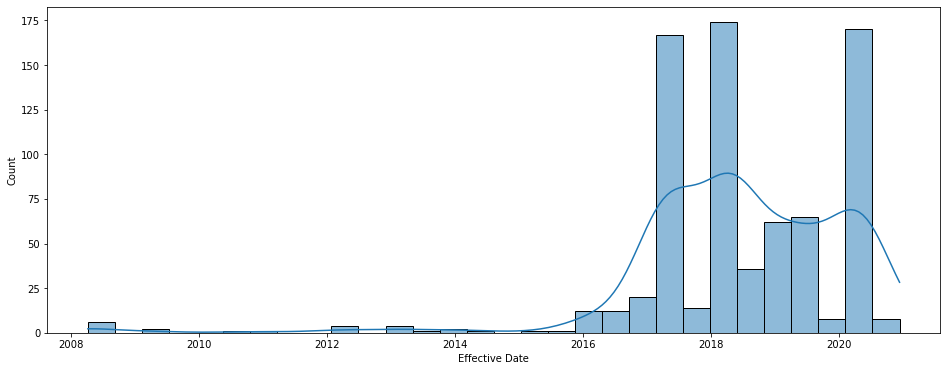

In [22]:
plt.figure(figsize=(16,6))
sns.histplot(df['Effective Date'],kde=True)

## Relative Date Distribution

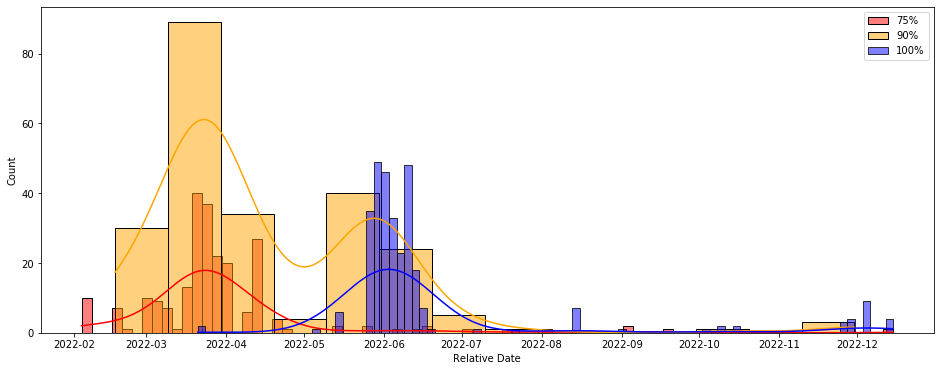

In [23]:
plt.figure(figsize=(16,6))
pct_dict = {75:'red',90:'orange',100:'blue'}
for pct, pct_color in pct_dict.items():
    sns.histplot(df[(df['Percentage']==pct)].sort_values(by=['Relative Date'],ascending=True)['Relative Date'], kde=True, label=f"{pct}%", color=pct_color)
plt.legend()

## Relative Date over Time

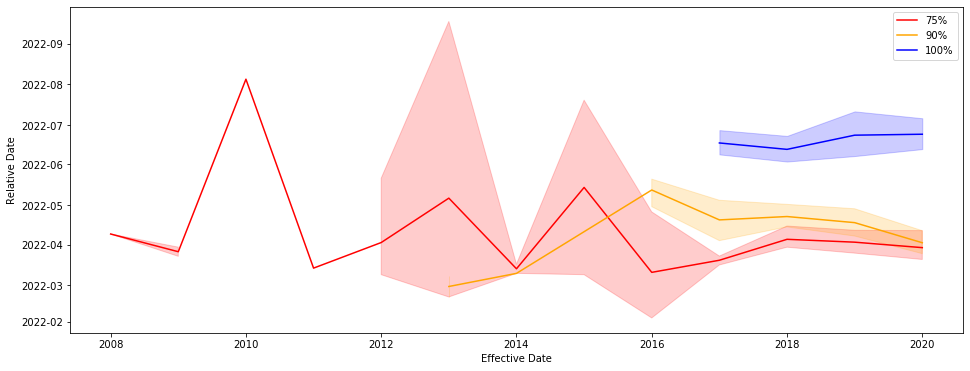

In [24]:
plt.figure(figsize=(16,6))
pct_dict = {75:'red',90:'orange',100:'blue'}
for pct, pct_color in pct_dict.items():
    try:
        sns.lineplot(x=df[df['Percentage']==pct]['Effective Date'].apply(lambda x: x.year), y=df[df['Percentage']==pct]['Relative Date'], label=f"{pct}%", color=pct_color)
    except:
        raise
plt.legend()

## Specific Road Analysis
Each road has its specific trends. Entering a road into the "key" variable below to view the road specific data

In [515]:
key = 'UAR 111: Urban Access Road 111 (Jct. 12 - Clive)'
print(df['Key'].unique())

['Jamieson Road: Jct. 1A - 2.3 km North (Stoney Indian Reserve #144 North Boundary)'
 '1A: 0.6 km East of Jct 1X - Jamieson Road (8.0 km West of Jct. 40)'
 '1A: Jamieson Road (8.0 km West of Jct. 40) - Ghost Lake Provincial'
 '2A: Recreation Area' '2A: Township Road 834 - Range Road 234'
 '10X: km 0.05 (Bridge #9 at Wayne) - km 4.05 (Bridge #2)'
 '10X: km 4.05 (Bridge #2) - km 5.61 (Jct. 10)'
 '22: Mayerthorpe - Jct. 18' '25: Jct. 521 - Jct. 526'
 '40: Cadomin Jct. (47.9 km S. of Jct. 16) - Teck Coal Cardinal Ops Access Rd'
 '40: (39.9 km S. of Jct. 16)'
 '40: Cadomin Junction (47.9 km South of Jct. 16) - 1.4 km South of Jct. 47'
 '40: Jct. 1A - MD8 Boundary (7.8 km North of Jct. 1A)'
 '40: Jct. 734 (1.3 km S of Lovett River) - 19.5 km S of Jct. 47 (100 m South of'
 '40: MD 8 Boundary (7.8 km North of Jct. 1A) - Richards Road (Range Road'
 'nan: 74)' nan
 '505: Gulf Plant Access Road (Range Road 292) - Waterton River'
 '505.0: Waterton River - Range Road 271 (by Glenwood)'
 '506.0: Ran

### Relative Date Distribution

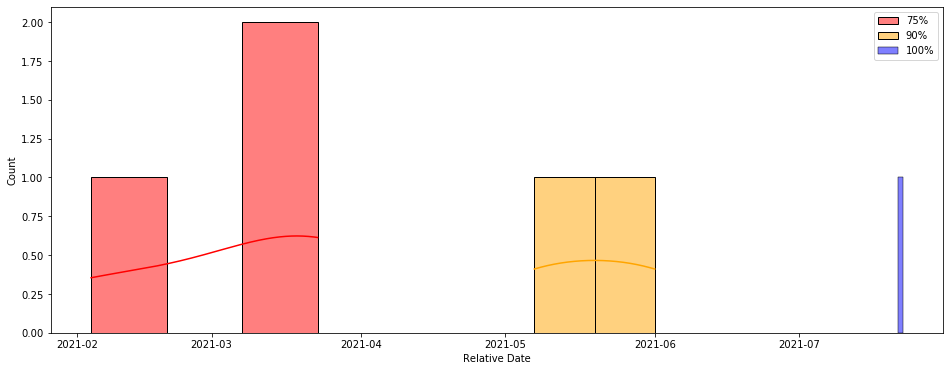

In [512]:
plt.figure(figsize=(16,6))
pct_dict = {75:'red',90:'orange',100:'blue'}
for pct, pct_color in pct_dict.items():
    sns.histplot(df[(df['Key']==key) & (df['Percentage']==pct)].sort_values(by=['Relative Date'],ascending=True)['Relative Date'], kde=True, label=f"{pct}%", color=pct_color)
plt.legend()

### Relative Offset Distribution

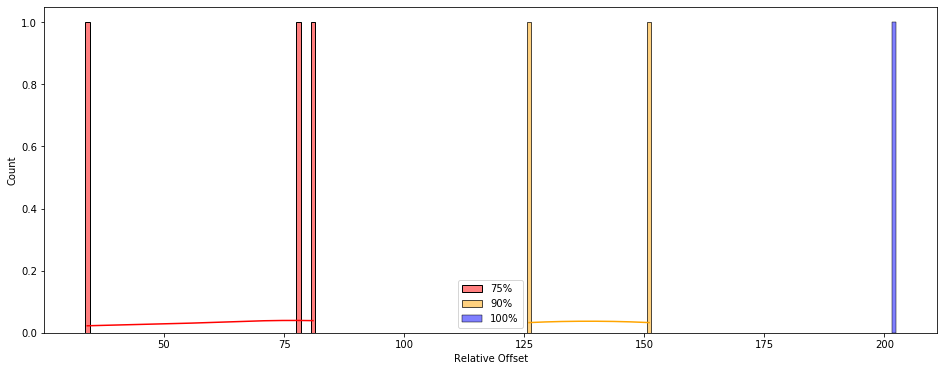

In [513]:
plt.figure(figsize=(16,6))
pct_dict = {75:'red',90:'orange',100:'blue'}
for pct, pct_color in pct_dict.items():
    sns.histplot(df[(df['Key']==key) & (df['Percentage']==pct)].sort_values(by=['Relative Date'],ascending=True)['Relative Offset']/1000000000/86400, kde=True, label=f"{pct}%", color=pct_color)
plt.legend()

## Time Series

In [467]:
key = '879.0: Jct. 501 - Jct. 61'
dft = df[df['Key']==key]
dft

,Road,Description,Distance,Effective Date,Percentage,Key,Relative Offset,Relative Date
190,879,Jct. 501 - Jct. 61,29.2,2017-06-12,100,879.0: Jct. 501 - Jct. 61,162 days,2021-06-12
191,879,Jct. 501 - Jct. 61,29.2,2017-02-17,90,879.0: Jct. 501 - Jct. 61,47 days,2021-02-17
766,879,Jct. 501 - Jct. 61,29.2,2020-06-04,100,879.0: Jct. 501 - Jct. 61,155 days,2021-06-05
767,879,Jct. 501 - Jct. 61,29.2,2020-03-02,90,879.0: Jct. 501 - Jct. 61,61 days,2021-03-03


### Relative Date over Time

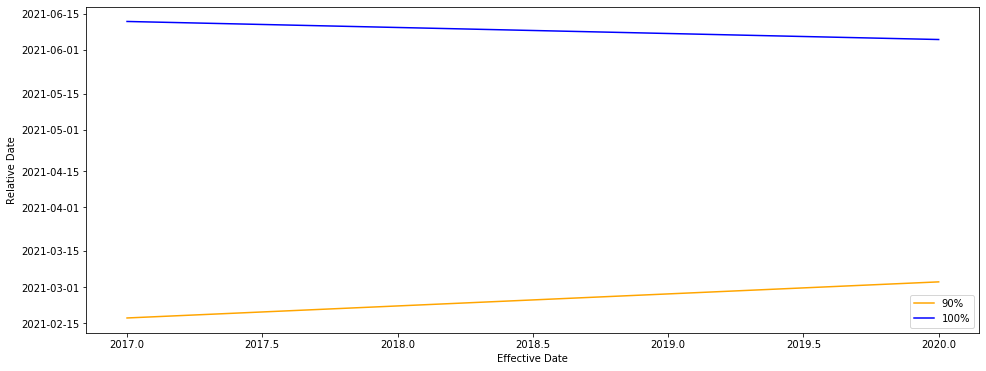

In [511]:
plt.figure(figsize=(16,6))
pct_dict = {75:'red',90:'orange',100:'blue'}
for pct, pct_color in pct_dict.items():
    try:
        sns.lineplot(x=dft[dft['Percentage']==pct]['Effective Date'].apply(lambda x: x.year), y=dft[dft['Percentage']==pct]['Relative Date'], label=f"{pct}%", color=pct_color)
    except:
        raise
plt.legend()

### Relative Offset over Time

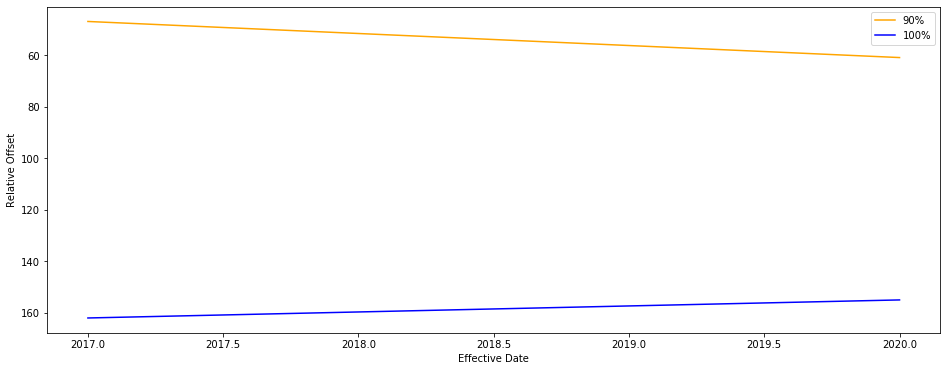

In [514]:
plt.figure(figsize=(16,6))
pct_dict = {75:'red',90:'orange',100:'blue'}
for pct, pct_color in pct_dict.items():
    try:
        sns.lineplot(x=dft[dft['Percentage']==pct]['Effective Date'].apply(lambda x: x.year), y=dft[dft['Percentage']==pct]['Relative Offset']/1000000000/86400, label=f"{pct}%", color=pct_color)
    except:
        raise
plt.legend()